# Preguntas


- Es porque el dataset está desbalanceado y hay muy pocas negativas.

- Read *everything* before sending over; "argumente brevemente sobre ello"

- normalization is by default l2 in tfidfvectorizer

5. No agarra ning⌂n bi ni trigrama

Proyecto 1 - Luis Eduardo Robles Jimenez

# Minería de Texto para Turismo

## Utils

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn import preprocessing
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
class TouristSpot:
    def __init__(self, path, vocabSize = None):
        self.reviews = pd.read_csv(path)
        self.spotName = path.split('/')[-1][: -4]
        self.vocabSize = vocabSize
        self.vectorizer = TfidfVectorizer(min_df = 1, stop_words = ['spanish', 'english'], norm = 'l2')
        self._cleanUp()
        self.nDashes = 30

    def _cleanUp(self):
        columns = ["Título de la opinión", "Opinión"]
        for col in columns:
            desc = []
            for o in self.reviews.loc[:, col]:
                if o[0] == '"': o = o[1:]
                if o[-1] == '"': o = o[:-1]
                desc.append(o)
            self.reviews.loc[:, col] = desc

        self.reviews['Número de aportaciones'] = self.reviews['Número de aportaciones'].fillna(0)

        if self.vocabSize is not None:
            corpus = ' '.join(self.reviews.loc[:, "Opinión"])
            self.vocabulary = FreqDist(word_tokenize(corpus)).most_common(self.vocabSize)
            self.vocabulary = [word for word, _ in self.vocabulary]

            def useTopWords(text):
                words = word_tokenize(text)
                return ' '.join([word if word in self.vocabulary else '<unk>' for word in words])

            self.reviews["Opinión"] = self.reviews["Opinión"].apply(useTopWords)

    def topKwordcloud(self, k = 50):
        print(f"{'-' * self.nDashes} {self.spotName} {'-' * self.nDashes}")
        bow = self.vectorizer.fit_transform(self.reviews["Opinión"])
        words = self.vectorizer.get_feature_names_out()

        feats = SelectKBest(chi2, k = k)
        #feats.fit(bow, self.reviews['Escala']) # Doesn't work that well because it's unbalanced
        feats.fit(bow, self.reviews['Número de aportaciones']) # Considers how verbose the author is
        best = feats.get_support(indices = True)
        words = ' '.join(words[best])

        self._wordcloud(words)

    def negativeWordcloud(self, k = 50):
        print(f"{'-' * self.nDashes} {self.spotName} {'-' * self.nDashes}")
        subgroup = self.reviews.loc[self.reviews.loc[:, 'Escala'] < 3]
        bow = self.vectorizer.fit_transform(subgroup.loc[:, "Opinión"])
        words = self.vectorizer.get_feature_names_out()

        feats = SelectKBest(chi2, k = np.min((k, bow.shape[1])))
        feats.fit(bow, subgroup['Escala'])
        best = feats.get_support(indices = True)
        words = ' '.join(words[best])

        self._wordcloud(words)

    def _wordcloud(self, words, freqs = False):
        if freqs: wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=3).generate_from_frequencies(words)
        else: wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=3).generate(words)
        plt.figure(figsize=(8,8))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad=0)
        plt.show()

    def LSA(self):
        print(f'{"-" * self.nDashes} {self.spotName} {"-" * self.nDashes}')

        subgroups = {}
        subgroups['Hombres'] = self.reviews.loc[self.reviews.loc[:, 'Género'] == 'Masculino']
        subgroups['Mujeres'] = self.reviews.loc[self.reviews.loc[:, 'Género'] == 'Femenino']
        subgroups['Turistas Nacionales'] = self.reviews.loc[self.reviews.loc[:, 'Nacional ó Internacional'] == 'Nacional']
        subgroups['Turistas Internacionales'] = self.reviews.loc[self.reviews.loc[:, 'Nacional ó Internacional'] == 'Internacional']
        subgroups['Jovenes (10, 30)'] = self.reviews.loc[np.logical_and(self.reviews.loc[:, 'Edad'] > 0, self.reviews.loc[:, 'Edad'] < 30)]
        subgroups['Mayores (60, 100)'] = self.reviews.loc[np.logical_and(self.reviews.loc[:, 'Edad'] > 60, self.reviews.loc[:, 'Edad'] < 100)]

        for sName in subgroups:
            s = subgroups[sName]
            print(f'Subgroup: {sName}')
            bow = self.vectorizer.fit_transform(s.loc[:, 'Opinión'])
            #bow = preprocessing.normalize(bow, norm = 'l2')
            dictionary = self.vectorizer.get_feature_names_out()
            svd = TruncatedSVD(n_components = 3)
            lsa = svd.fit_transform(bow)

            for comp in svd.components_:
                sortedComp = np.argsort(np.abs(comp))[::-1]
                comp = comp[sortedComp]
                dictionary = dictionary[sortedComp]
                for term in dictionary[:10]: print(f'{term}', end = " ")
                print()
            print()

    def ngramsAnalysis(self):
        print(f'{"-" * self.nDashes} {self.spotName} {"-" * self.nDashes}')

        unigrams = TfidfVectorizer(stop_words = ['spanish', 'english'], norm = 'l2', max_features = 1000, ngram_range = (1, 1))
        bigrams = TfidfVectorizer(stop_words = ['spanish', 'english'], norm = 'l2', max_features = 2000, ngram_range = (2, 2))
        trigrams = TfidfVectorizer(stop_words = ['spanish', 'english'], norm = 'l2', max_features = 1000, ngram_range = (3, 3))
        uni = np.array(unigrams.fit_transform(self.reviews["Opinión"]).todense())
        bi = np.array(bigrams.fit_transform(self.reviews["Opinión"]).todense())
        tri = np.array(trigrams.fit_transform(self.reviews["Opinión"]).todense())
        unis, bis, tris = unigrams.get_feature_names_out(), bigrams.get_feature_names_out(), trigrams.get_feature_names_out()
        bow = np.hstack((uni, bi, tri))
        words = np.hstack((unis, bis, tris))

        feats = SelectKBest(chi2, k = 1000)
        feats.fit(bow, self.reviews['Escala'])
        print(feats.get_support(indices = True))
        best = feats.scores_[feats.get_support(indices = True)]
        best = np.argsort(best)[-50:] # Get the top 50 out of 1000. It takes only unigrams
        ngrams = words[best]
        ngrams = {x: i for i, x in enumerate(ngrams)}
        self._wordcloud(ngrams, True)

    def temporalAnalysis(self):
        self.reviews['newDate'] = ['/'.join(date.split('/')[1:]) for date in self.reviews.loc[:, 'Fecha']]

        dates = []
        bad, neutral, good, total = [], [], [], []
        for groupName, reviewsGroup in self.reviews.groupby('newDate'):
            dates.append(groupName)
            bad.append(np.sum(reviewsGroup.loc[:, 'Escala'] < 3))
            neutral.append(np.sum(reviewsGroup.loc[:, 'Escala'] == 3))
            good.append(np.sum(reviewsGroup.loc[:, 'Escala'] > 3))

        grades = np.array(bad) + np.array(neutral) + np.array(good)
        bad =       np.array(bad)       / grades * 100
        neutral =   np.array(neutral)   / grades * 100
        good =      np.array(good)      / grades * 100

        argsort = np.argsort([datetime.strptime(date, '%m/%y' if len(date) == 5 else '%m/%Y') for date in dates])[::-1]
        dates =     np.array([dates[i] for i in argsort])
        bad =       np.array([bad[i] for i in argsort])
        neutral =   np.array([neutral[i] for i in argsort])
        good =      np.array([good[i] for i in argsort])

        _, stackedChart = plt.subplots(figsize = (15, 15))
        stackedChart.barh(dates, good, label='Good reviews', color = '#00ff00')
        stackedChart.barh(dates, neutral, left = good, label='Neutral reviews', color = '#ffff00')
        stackedChart.barh(dates, bad, left = good + neutral, label='Bad reviews', color = '#ff0000')
        stackedChart.legend()
        stackedChart.set_title(f'Reviews of {self.spotName} by month')
        plt.show()

    def describe(self):
        nRows, nCols = 2, 1
        fig = plt.figure(figsize = (15, 10))
        fig.subplots_adjust(hspace = 0.5)

        print(self.nDashes * '-', self.spotName, self.nDashes * '-')

        grades = fig.add_subplot(321)
        avg = np.round(np.average(self.reviews.loc[:, 'Escala']), decimals = 2)
        sd = np.round(np.std(self.reviews.loc[:, 'Escala']), decimals = 2)
        grades.hist(self.reviews.loc[:, 'Escala'])
        grades.set_title(f"Grades (1 worst; 5 best); Average = {avg}; SD = {sd}")

        length = fig.add_subplot(322)
        lenOpinions = [len(word_tokenize(o)) for o in self.reviews.loc[:, 'Opinión']]
        avg = np.round(np.average(lenOpinions), decimals = 2)
        sd = np.round(np.std(lenOpinions), decimals = 2)
        length.hist(lenOpinions)
        length.set_title(f"Length of opinions (words); Average = {avg}; SD = {sd}")

        ages = fig.add_subplot(323)
        ages.hist(self.reviews.loc[:, 'Edad'], bins = 10)
        ages.set_title(f'Ages distribution')

        visitors = fig.add_subplot(324)
        visitors.hist(self.reviews.loc[:, 'Nacional ó Internacional'])
        visitors.set_title('Local or foreigner')

        monthNames = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
        popularity = fig.add_subplot(325)
        months = [int(d.split('/')[1]) for d in self.reviews.loc[:, 'Fecha']]
        m, c = np.unique(months, return_counts = True)
        popularity.bar(m, c)
        popularity.set_title('Popularity by month')
        popularity.set_xticks(np.arange(1, len(m) + 1), labels = monthNames)

        languages = fig.add_subplot(326)
        m, c = np.unique(self.reviews.loc[:, 'Idioma'], return_counts = True)
        languages.barh(m, c)
        languages.set_title('Language')

        plt.show()

## Actividades

In [3]:
path = "../../data/guanajuato/"
spots = [TouristSpot(os.path.join(path, d), vocabSize = 10000) for d in os.listdir(path)]
#spots = [TouristSpot(os.path.join(path, d), vocabSize = None) for d in os.listdir(path)]

------------------------------ Teatro Juárez ------------------------------


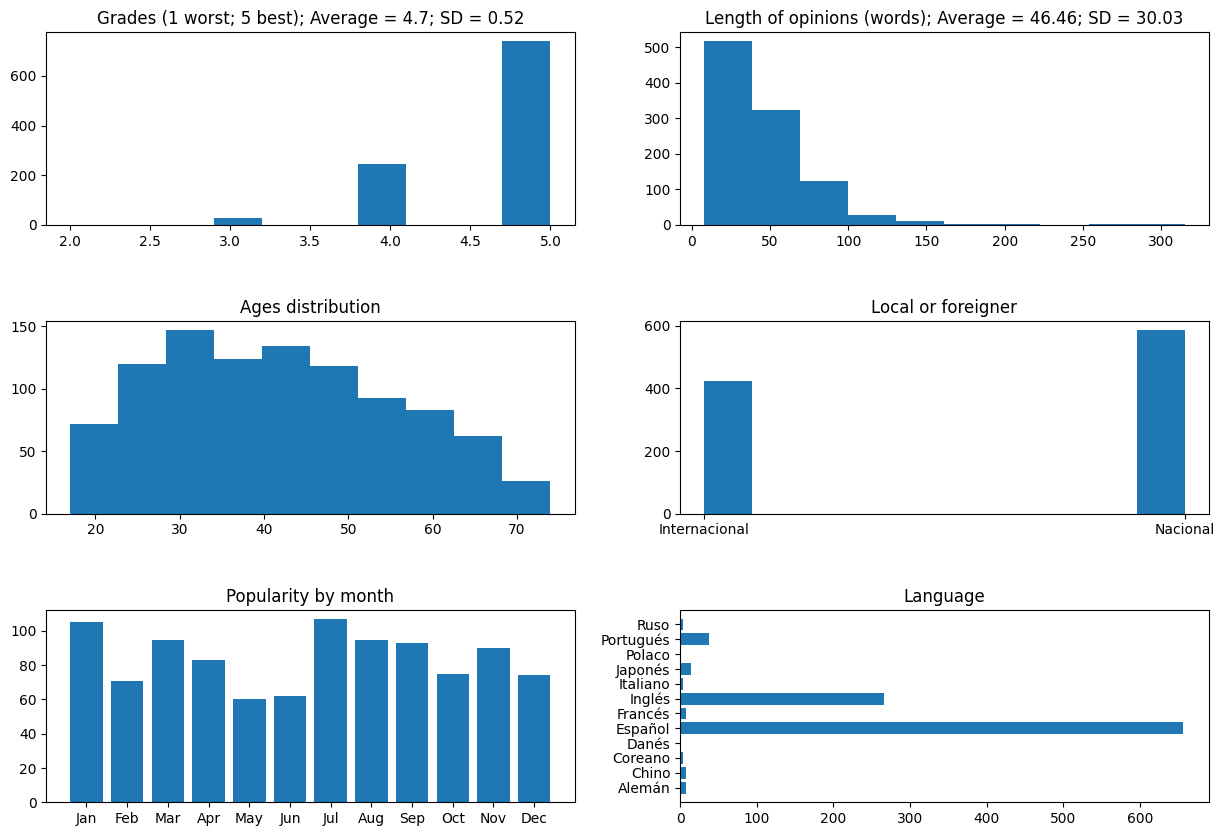

------------------------------ Mercado Hidalgo ------------------------------


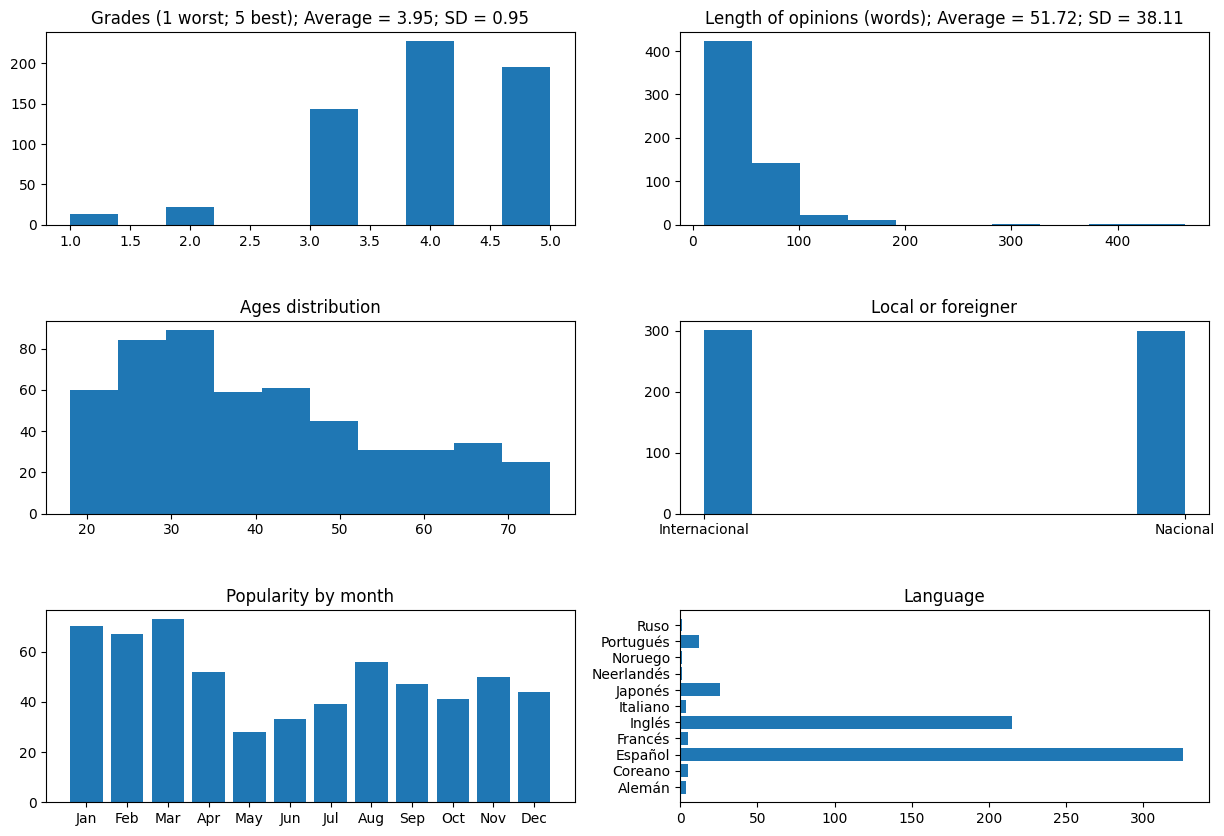

------------------------------ Museo de las Momias ------------------------------


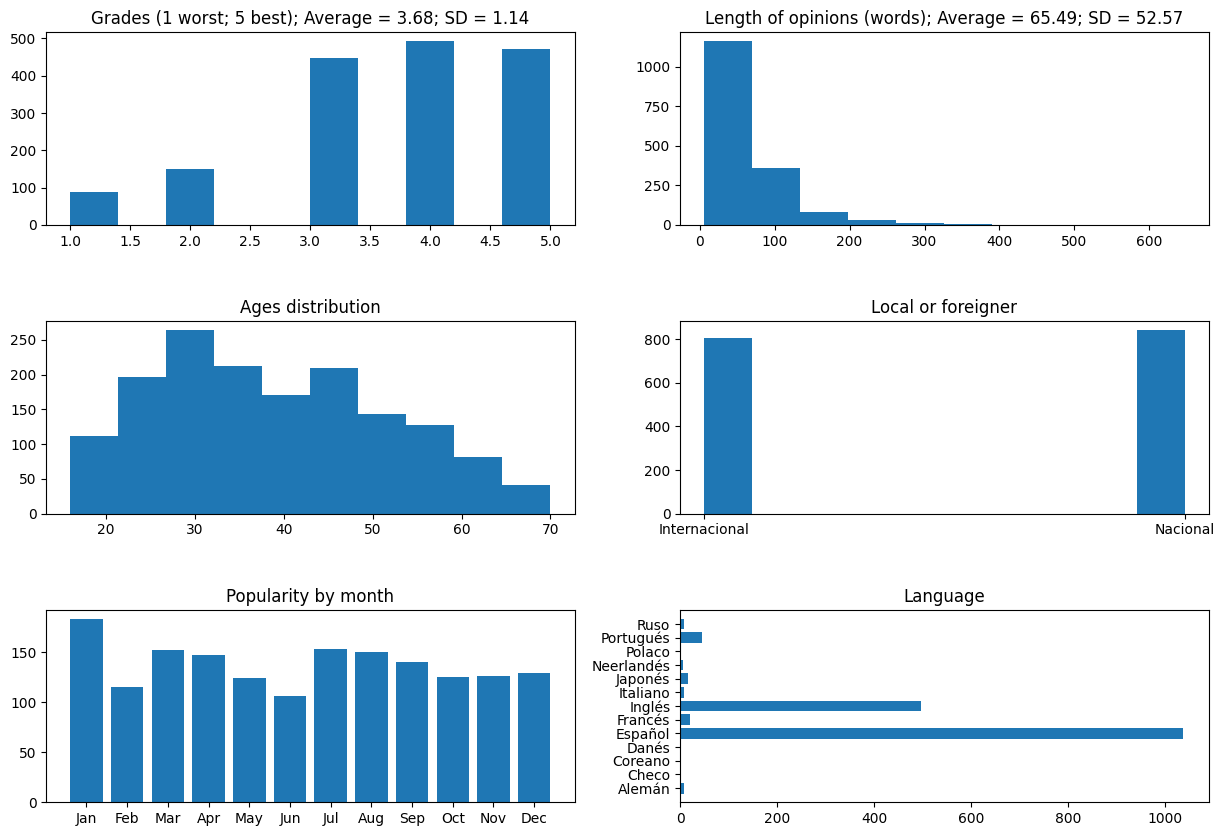

------------------------------ Basilica Colegiata ------------------------------


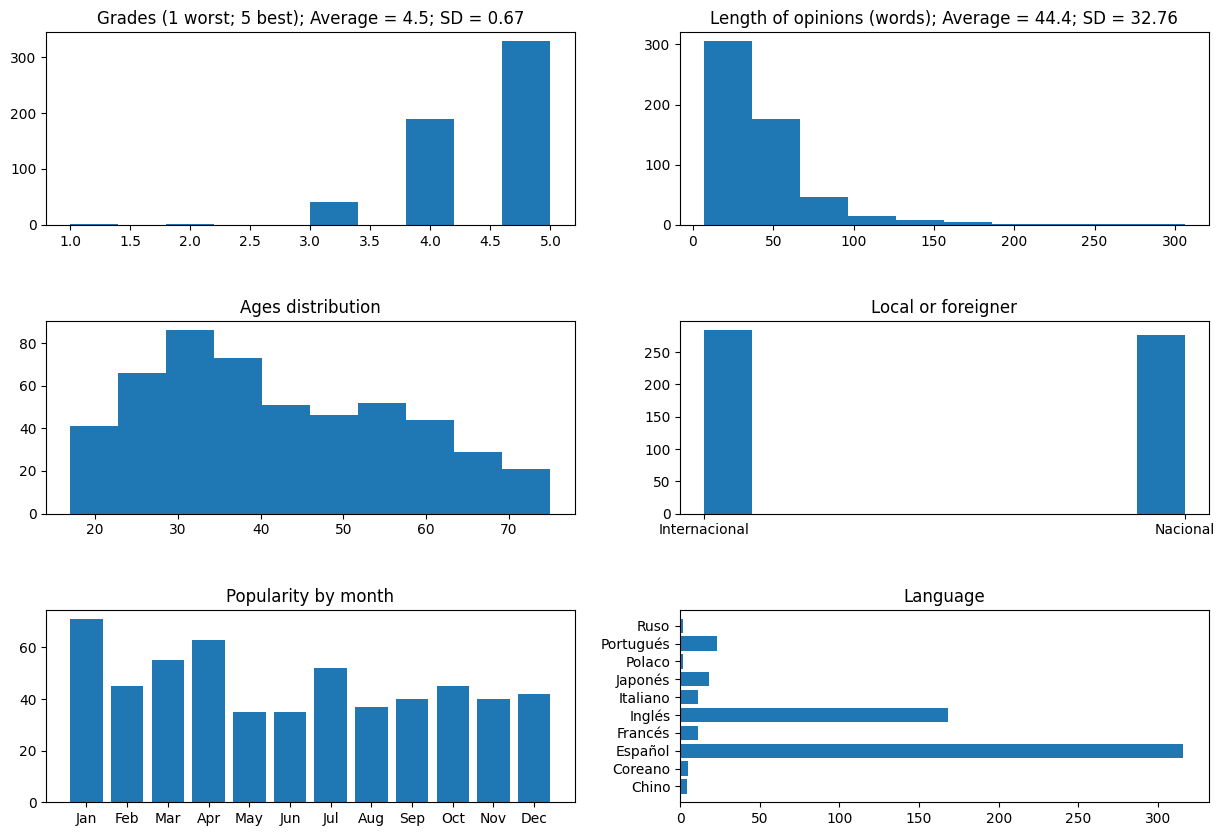

------------------------------ Universidad de Guanajuato ------------------------------


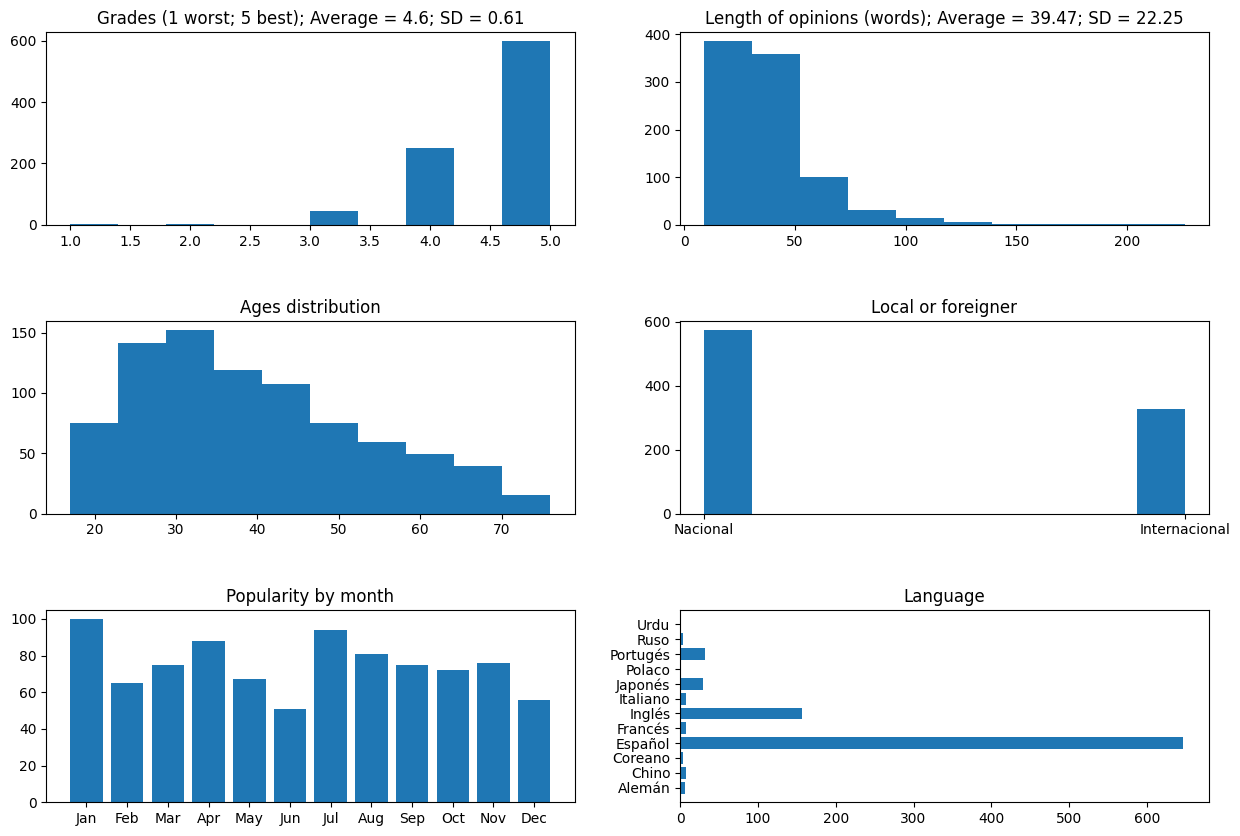

------------------------------ Jardín de la Unión ------------------------------


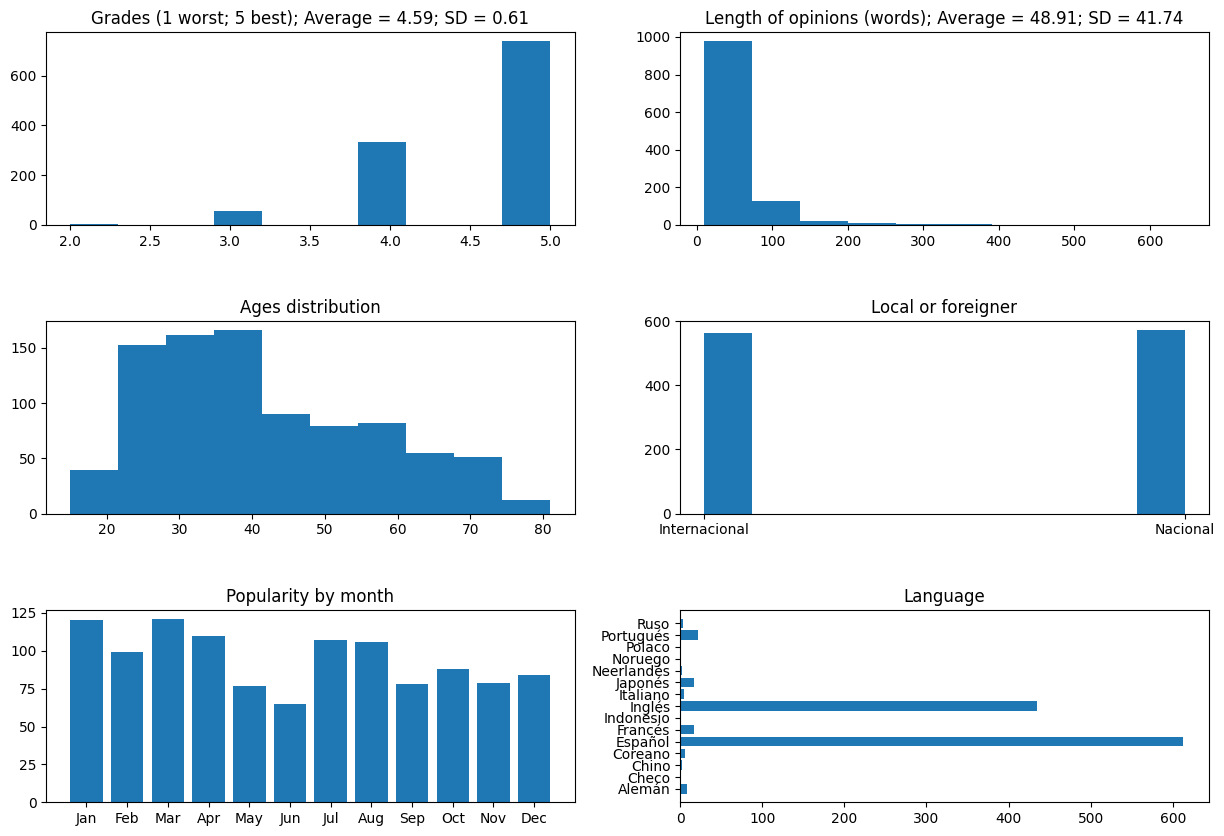

------------------------------ Callejón del Beso ------------------------------


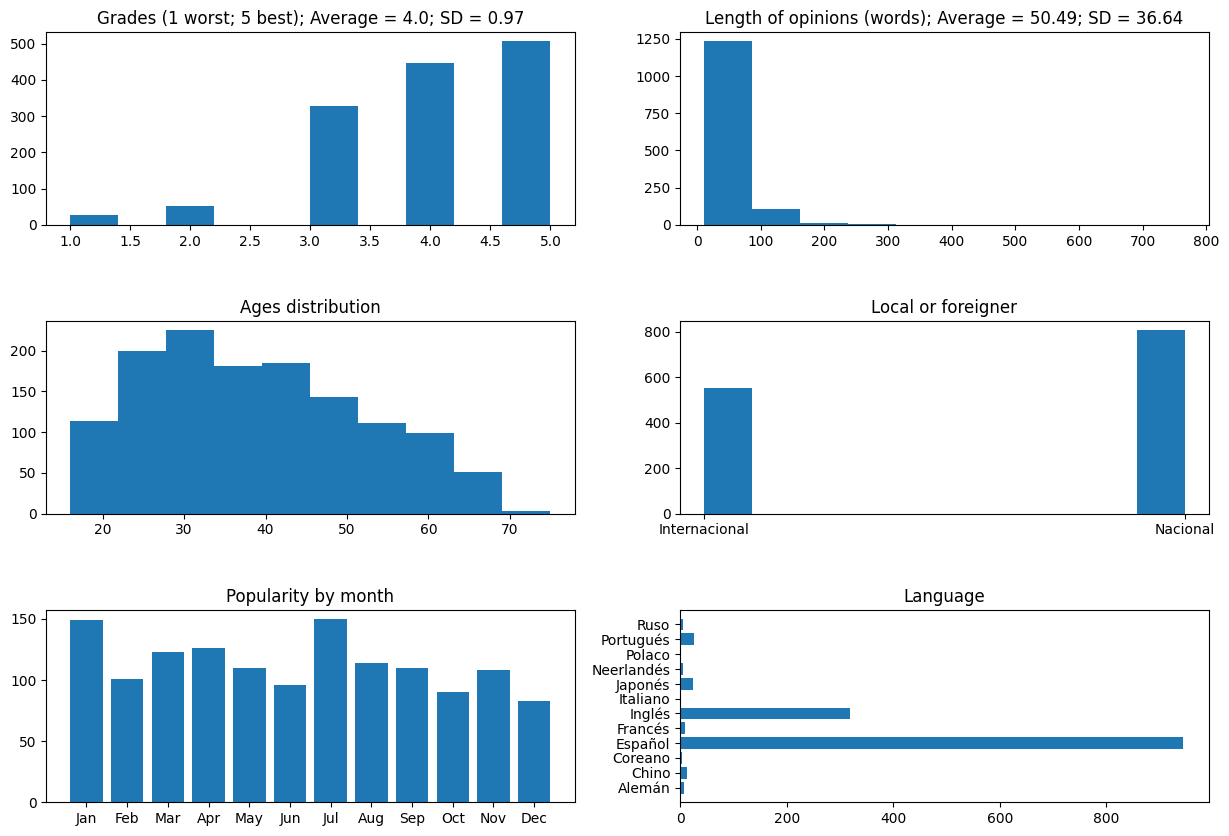

------------------------------ Monumento Pípila ------------------------------


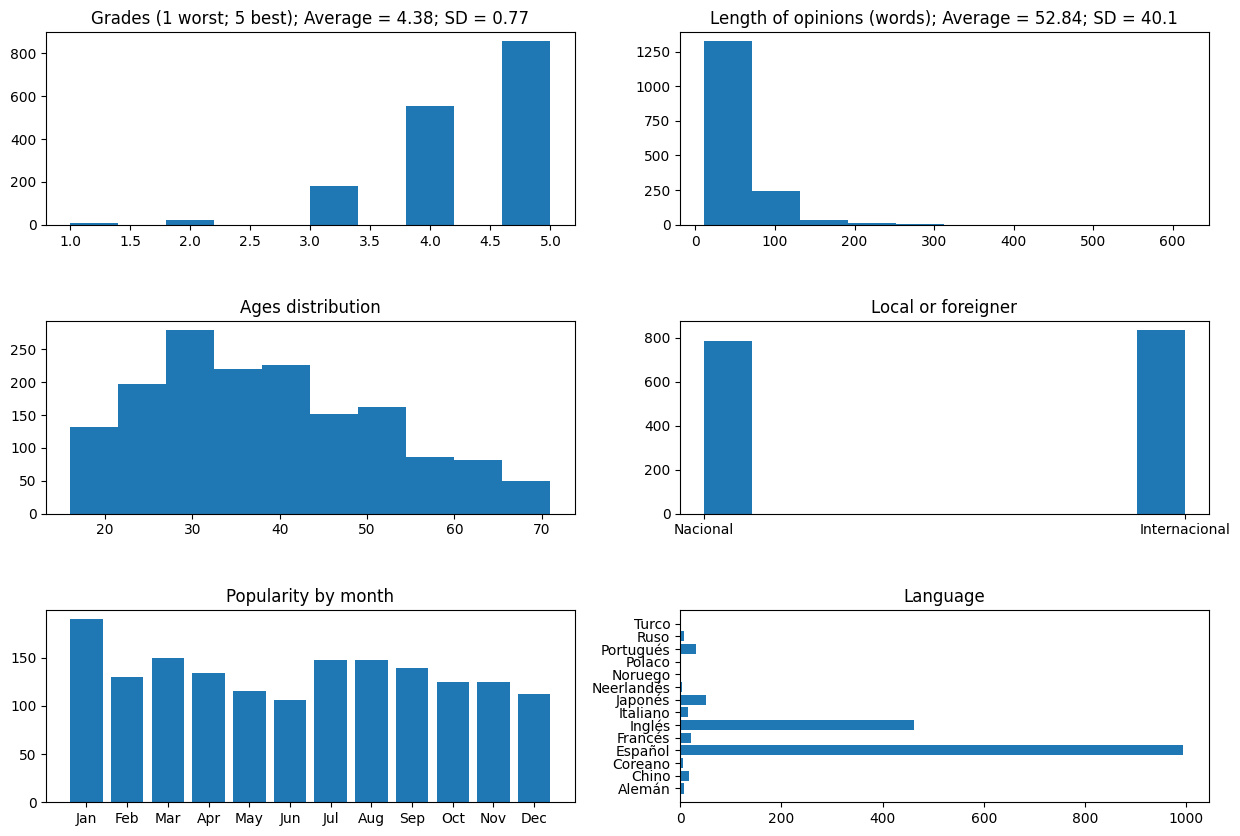

------------------------------ Alhóndiga ------------------------------


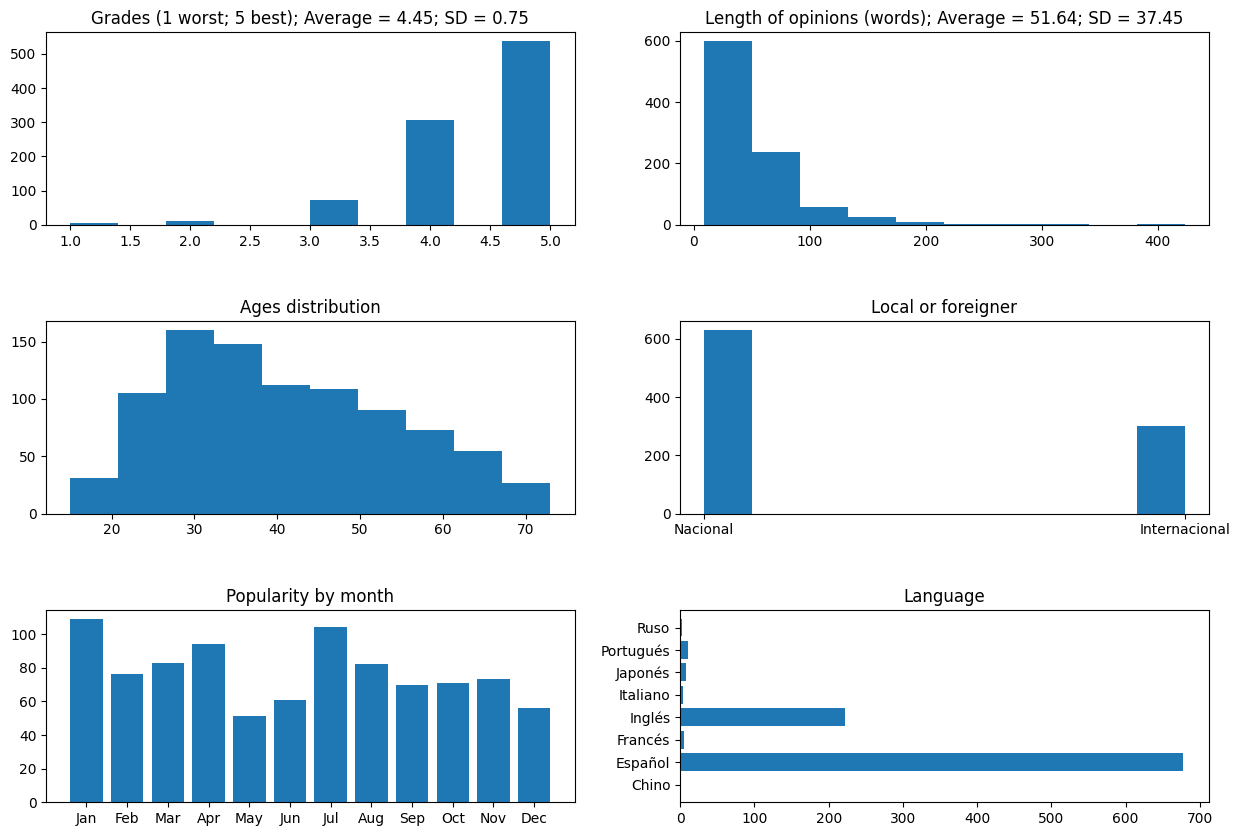

------------------------------ Casa de Diego Rivera ------------------------------


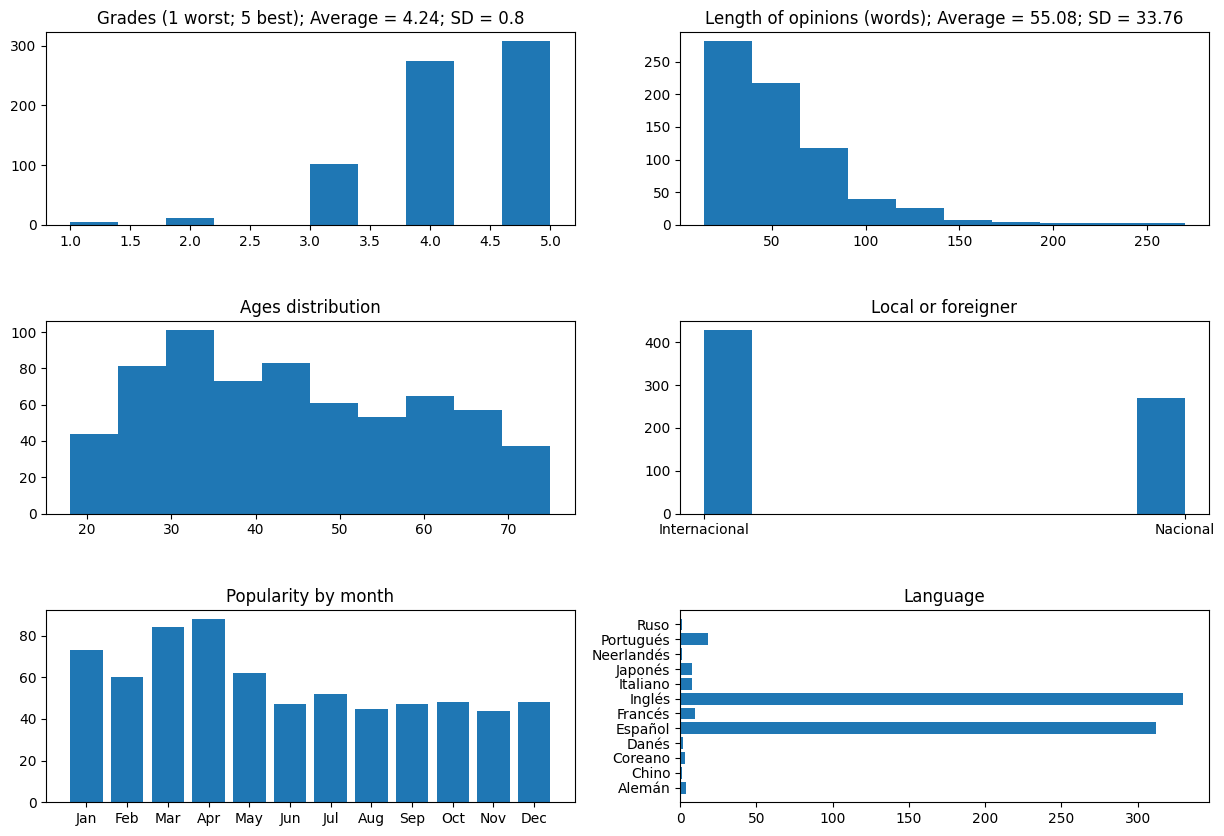

In [4]:
for spot in spots: 
    spot.describe()
    continue
    break

------------------------------ Teatro Juárez ------------------------------


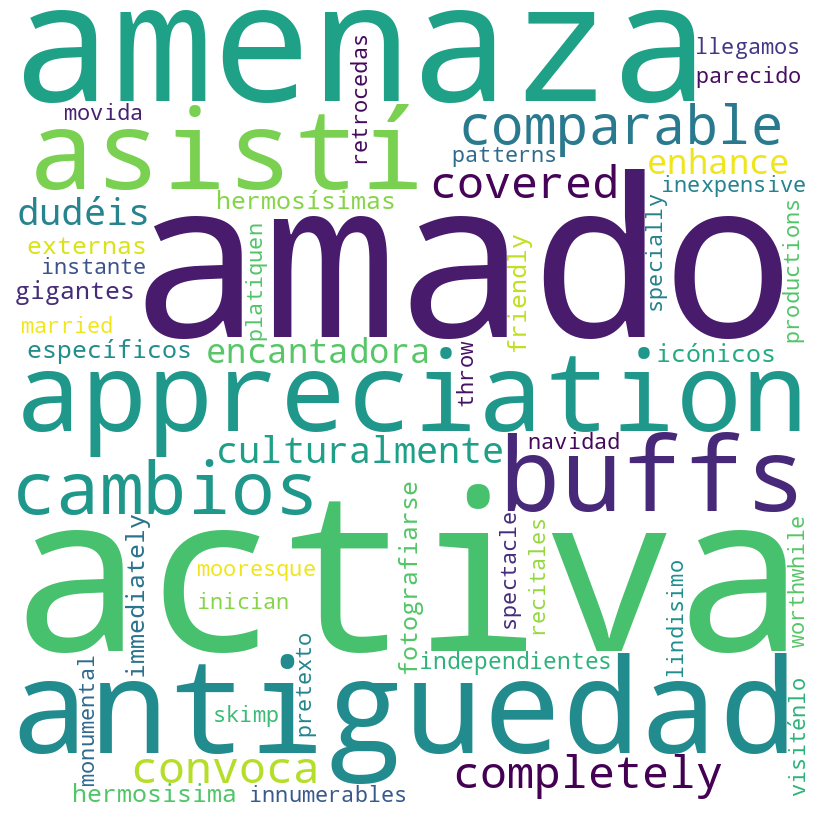

------------------------------ Mercado Hidalgo ------------------------------


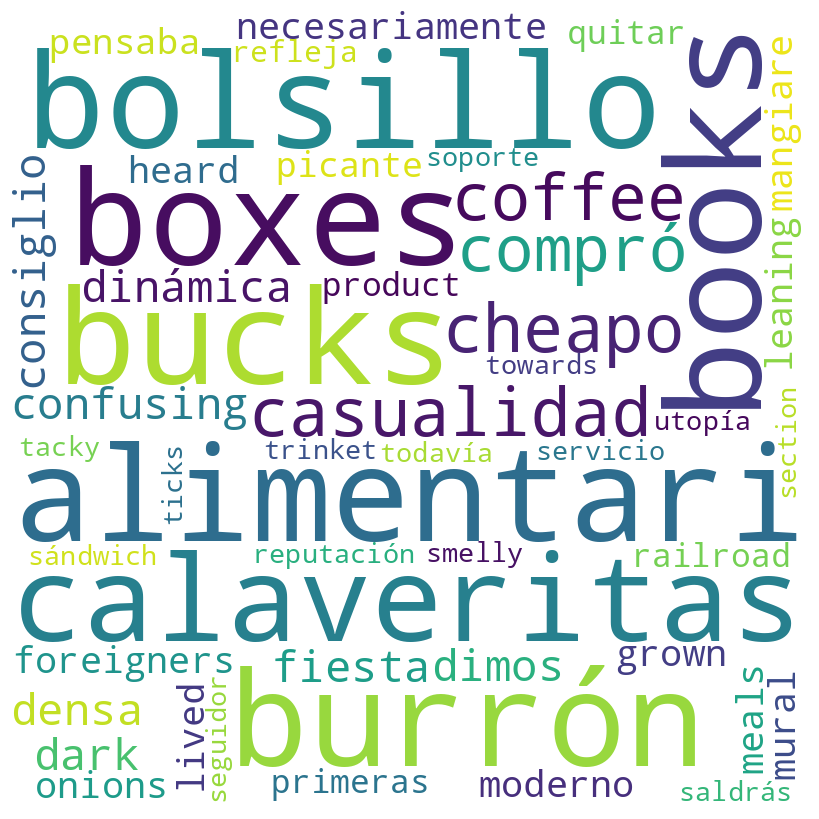

------------------------------ Museo de las Momias ------------------------------


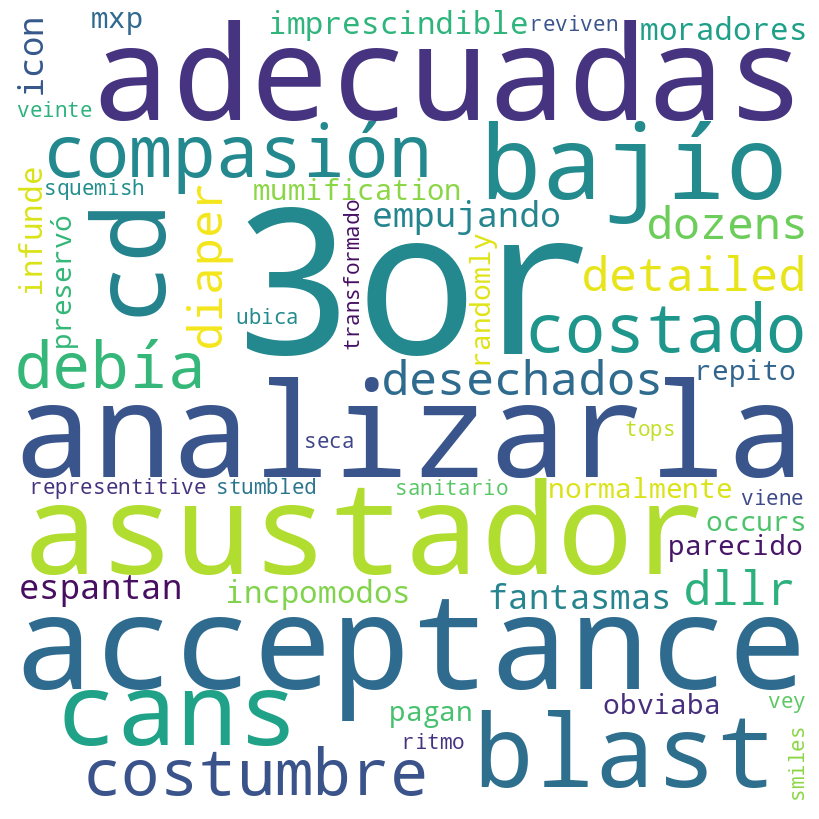

------------------------------ Basilica Colegiata ------------------------------


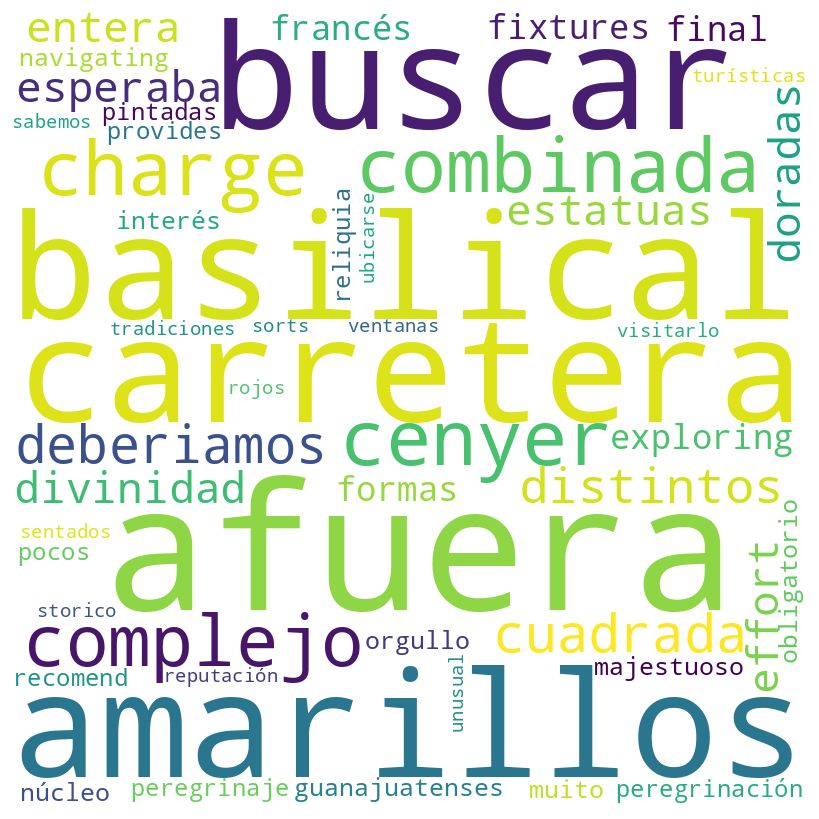

------------------------------ Universidad de Guanajuato ------------------------------


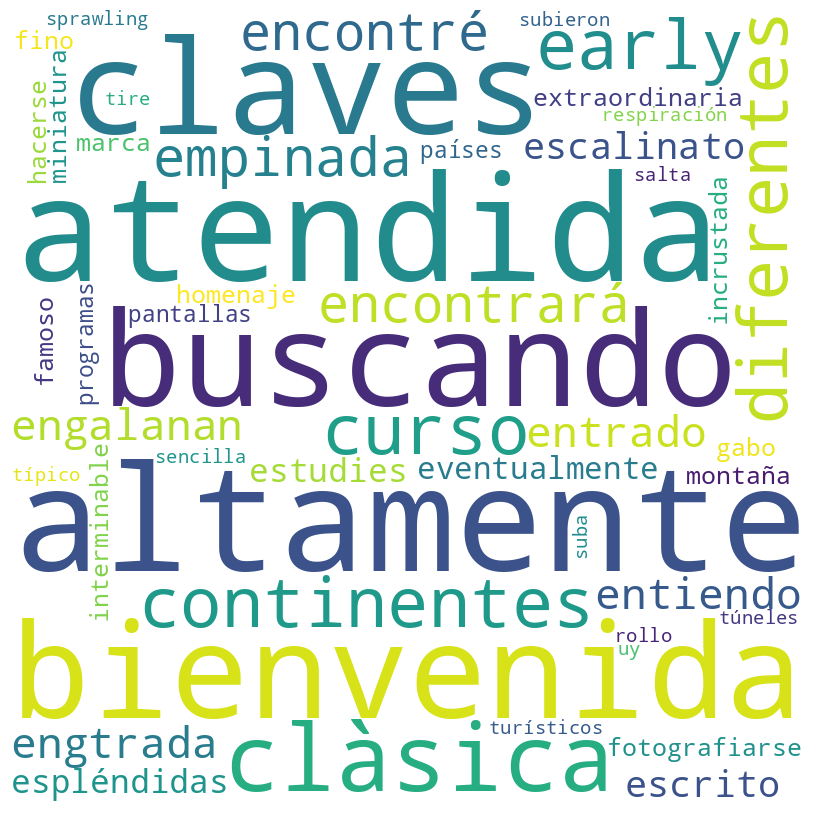

------------------------------ Jardín de la Unión ------------------------------


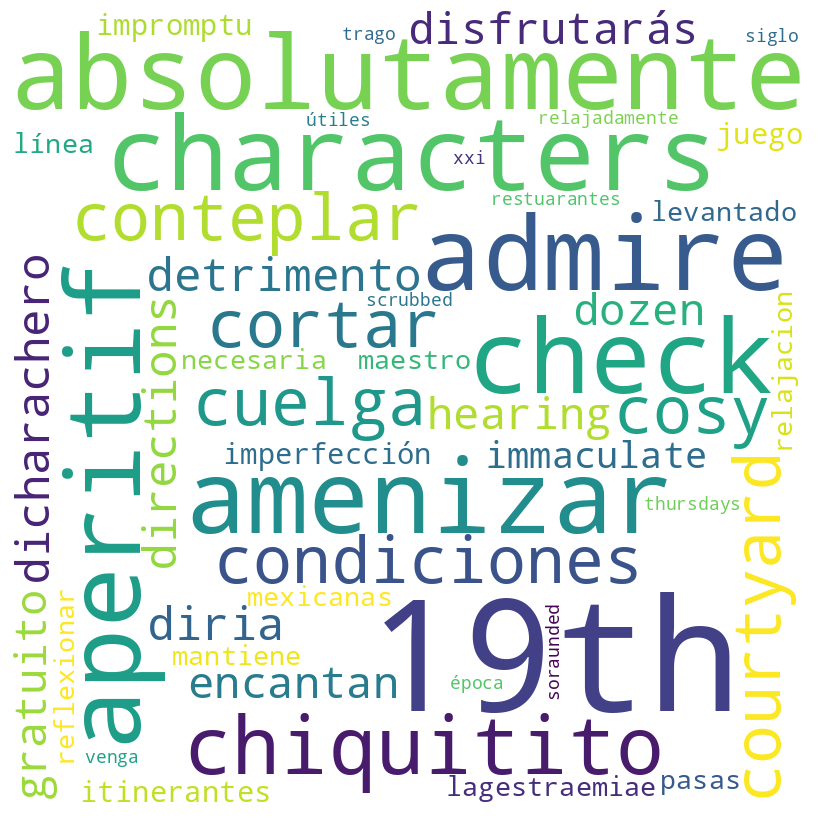

------------------------------ Callejón del Beso ------------------------------


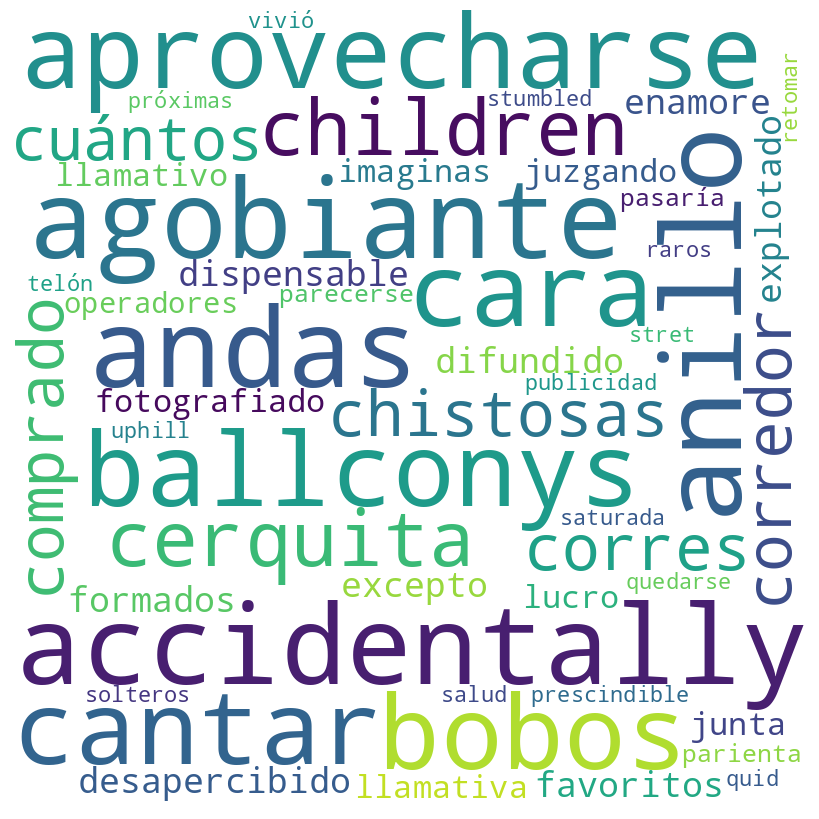

------------------------------ Monumento Pípila ------------------------------


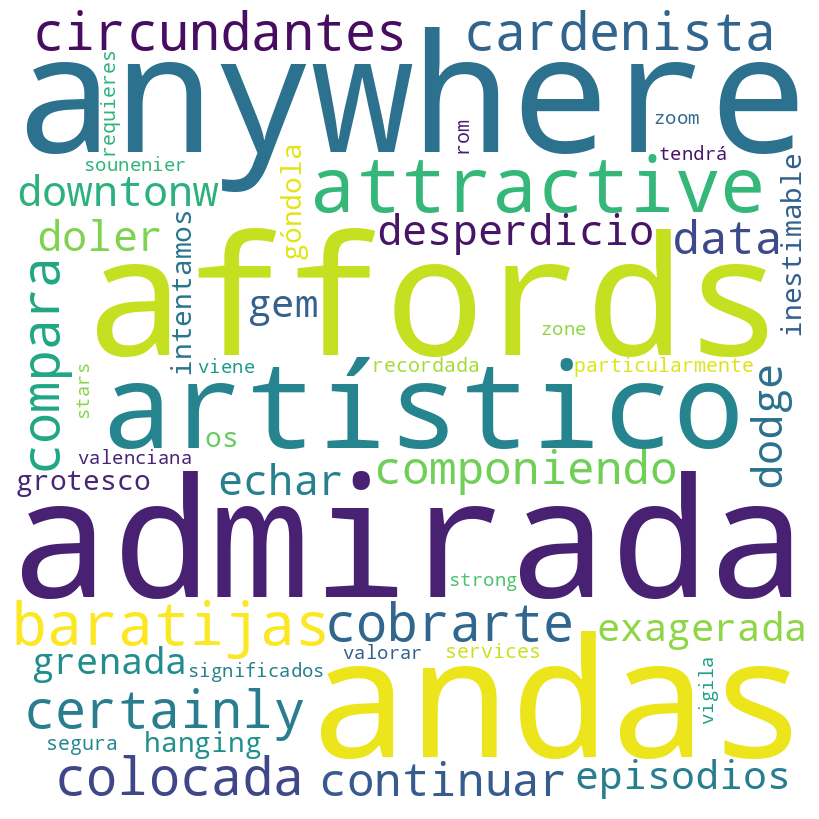

------------------------------ Alhóndiga ------------------------------


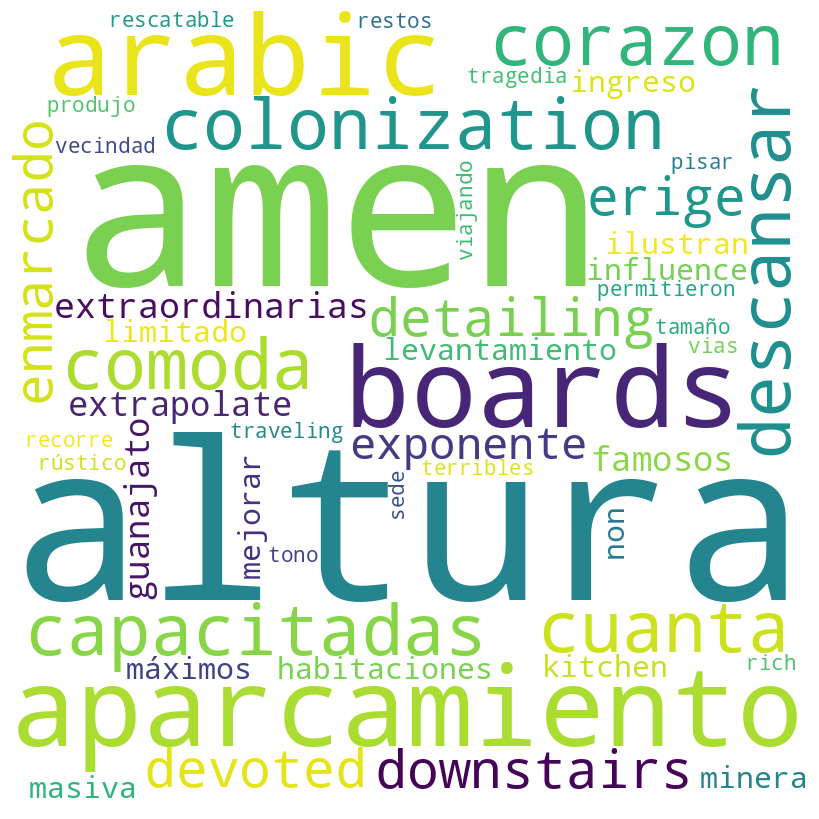

------------------------------ Casa de Diego Rivera ------------------------------


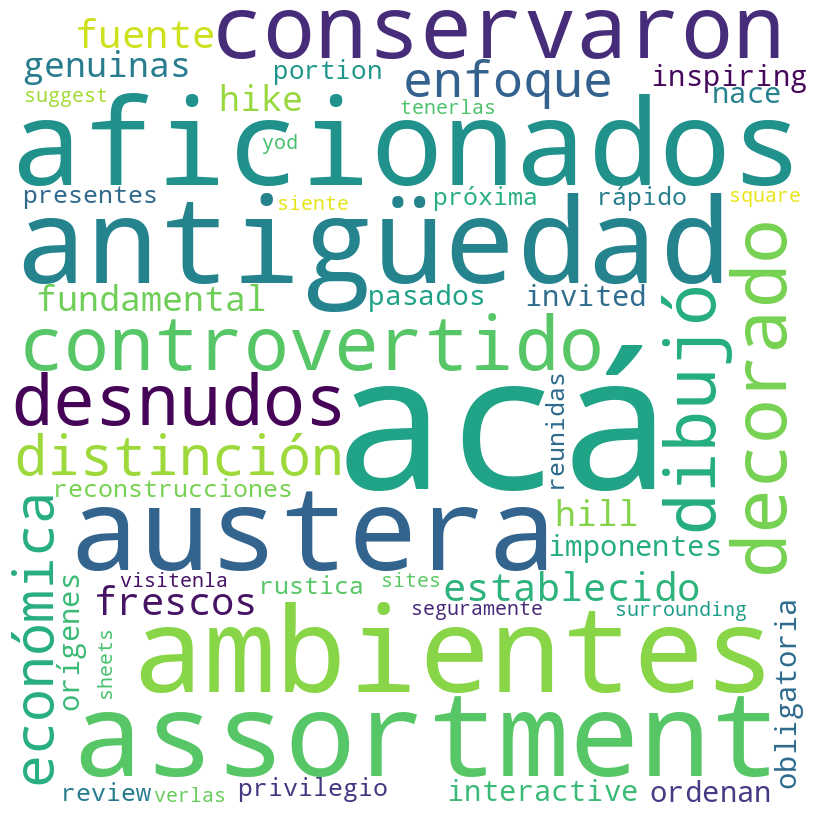

In [5]:
for spot in spots: 
    spot.topKwordcloud()
    continue
    break

------------------------------ Teatro Juárez ------------------------------


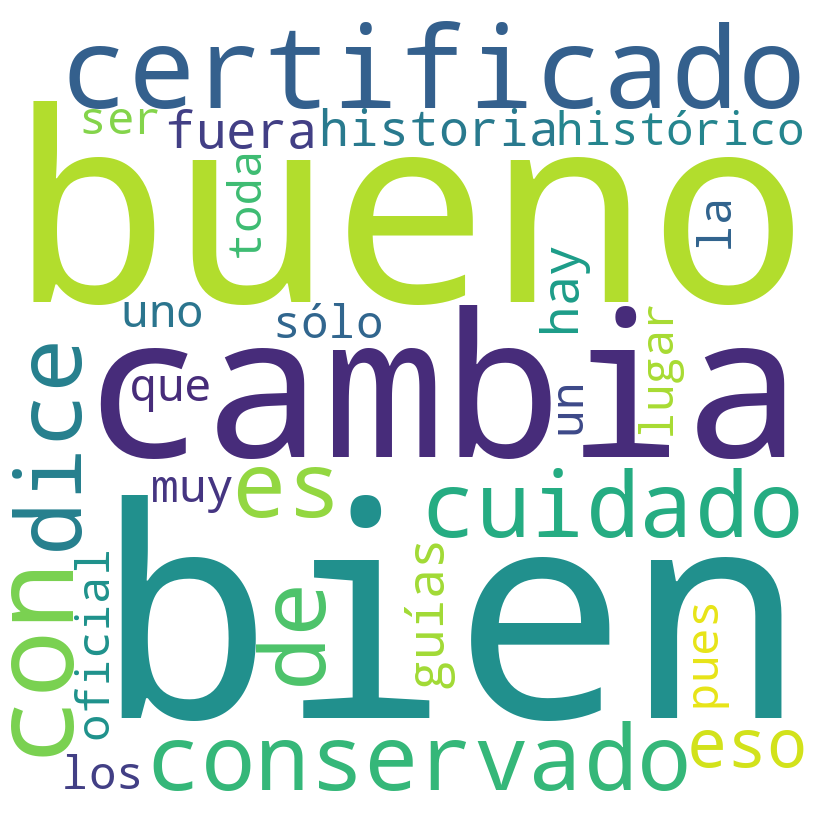

------------------------------ Mercado Hidalgo ------------------------------


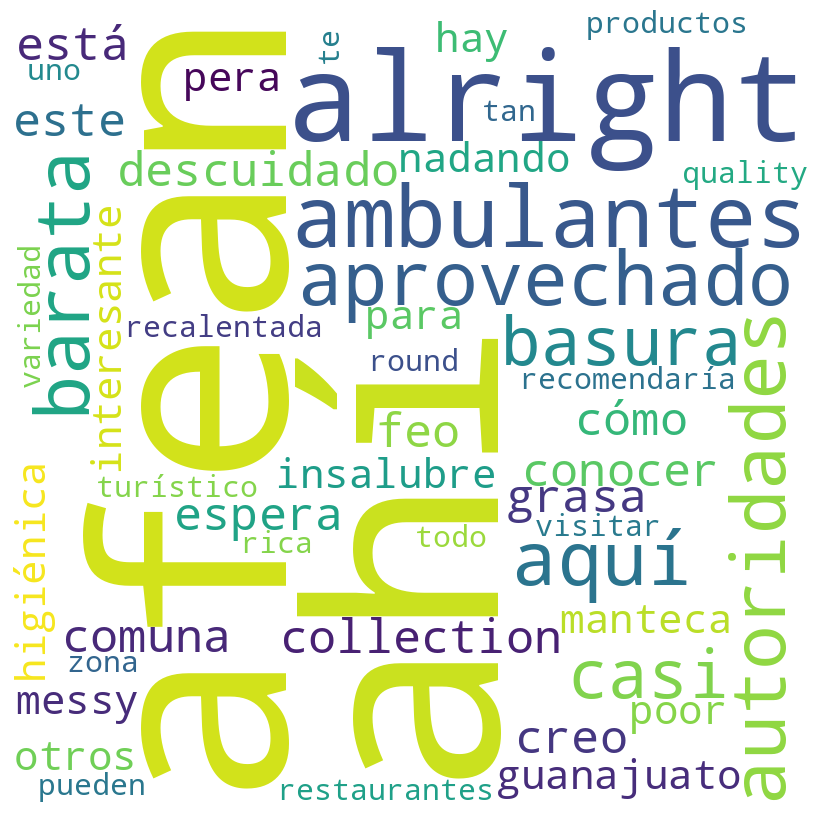

------------------------------ Museo de las Momias ------------------------------


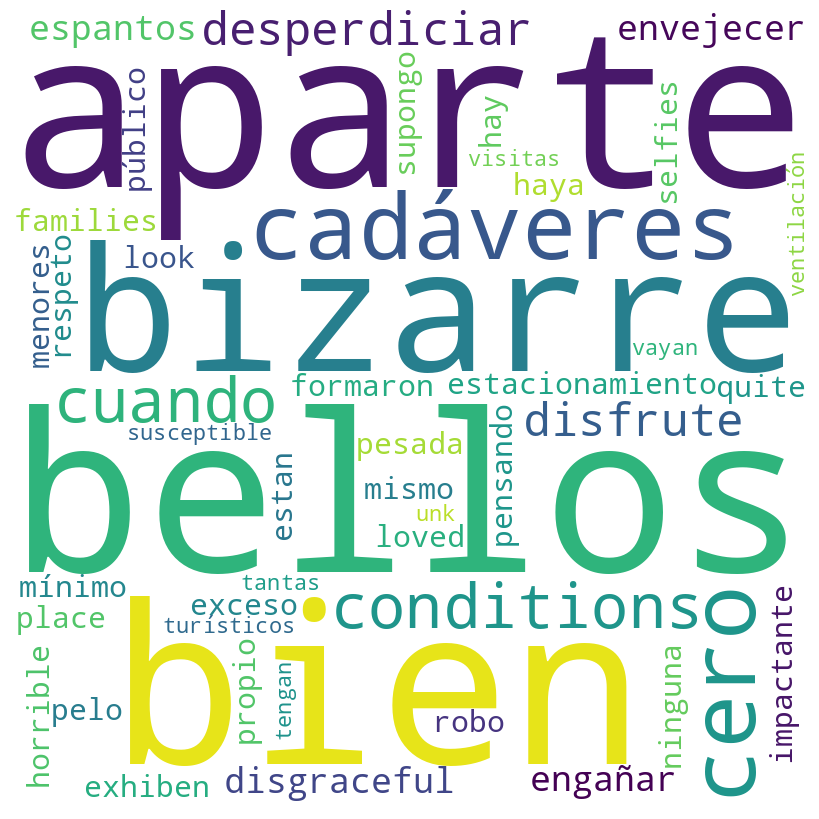

------------------------------ Basilica Colegiata ------------------------------


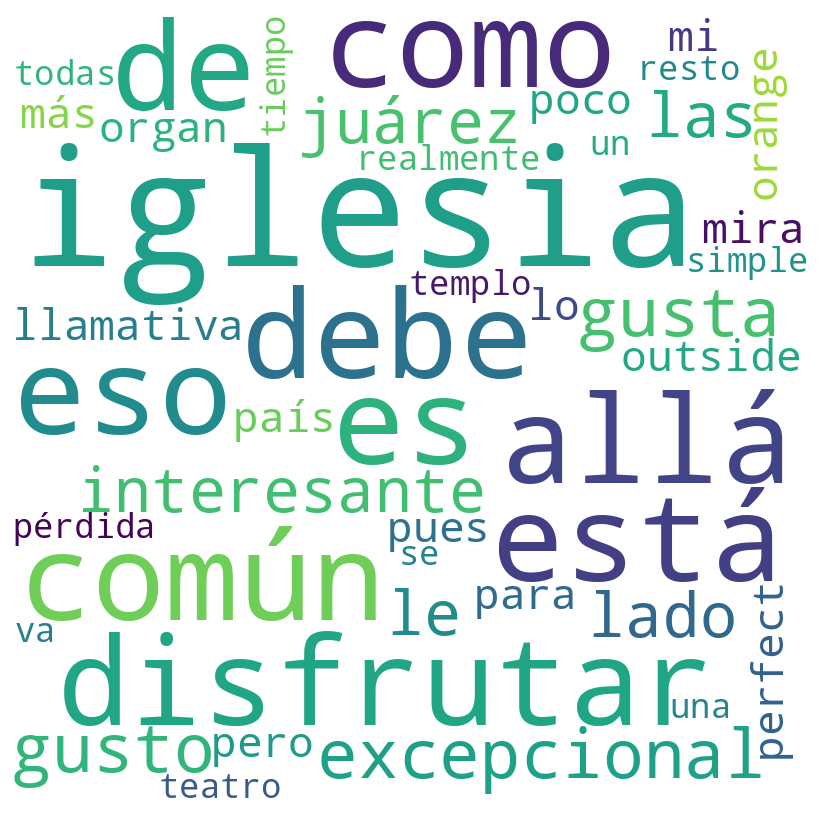

------------------------------ Universidad de Guanajuato ------------------------------


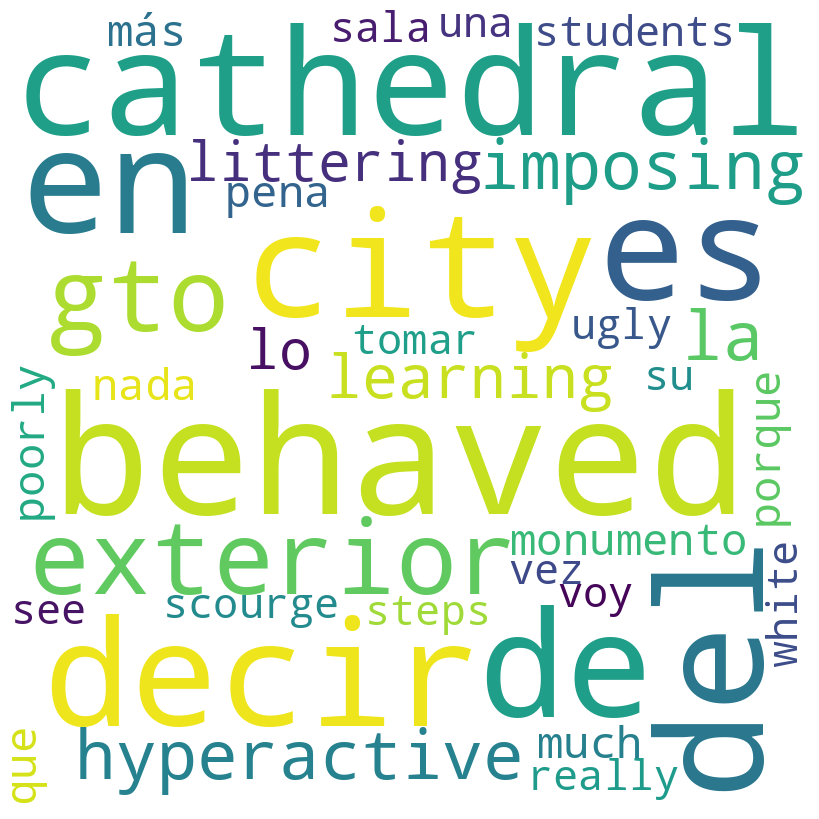

------------------------------ Jardín de la Unión ------------------------------


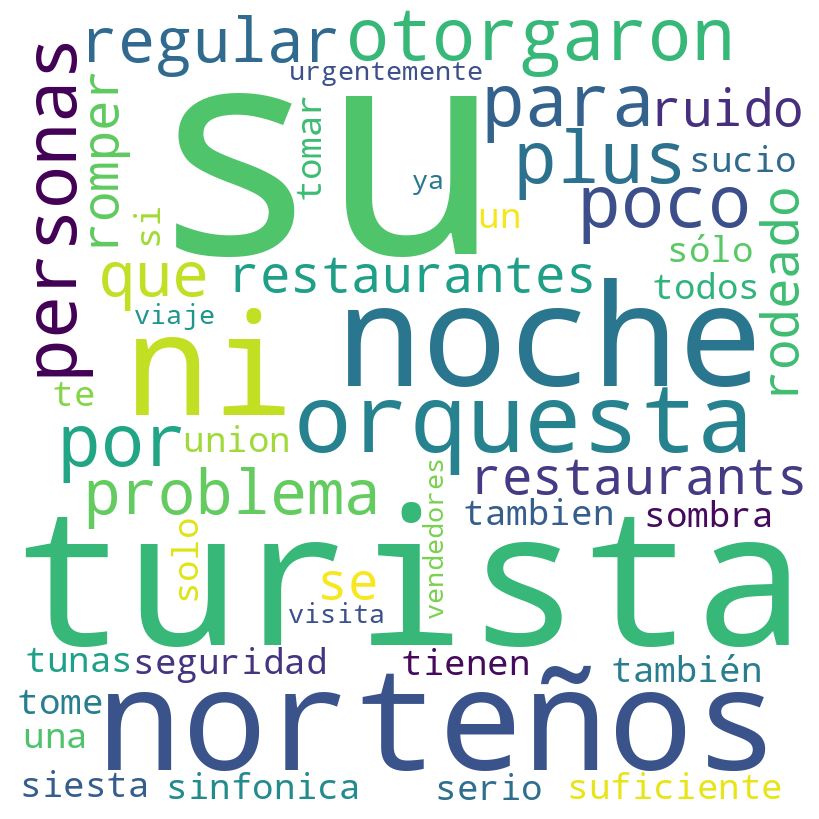

------------------------------ Callejón del Beso ------------------------------


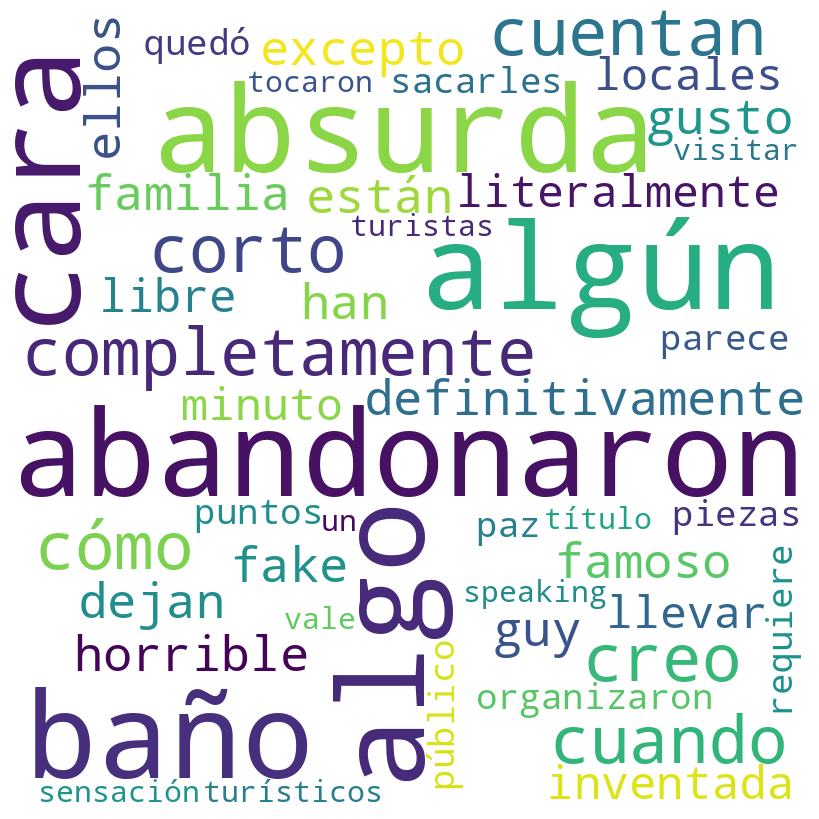

------------------------------ Monumento Pípila ------------------------------


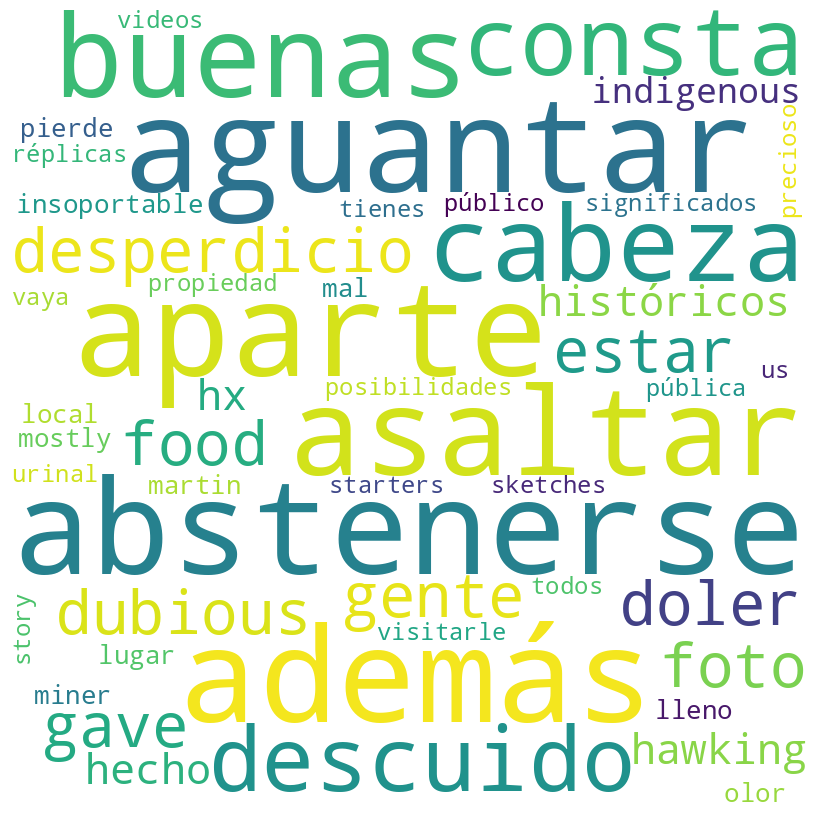

------------------------------ Alhóndiga ------------------------------


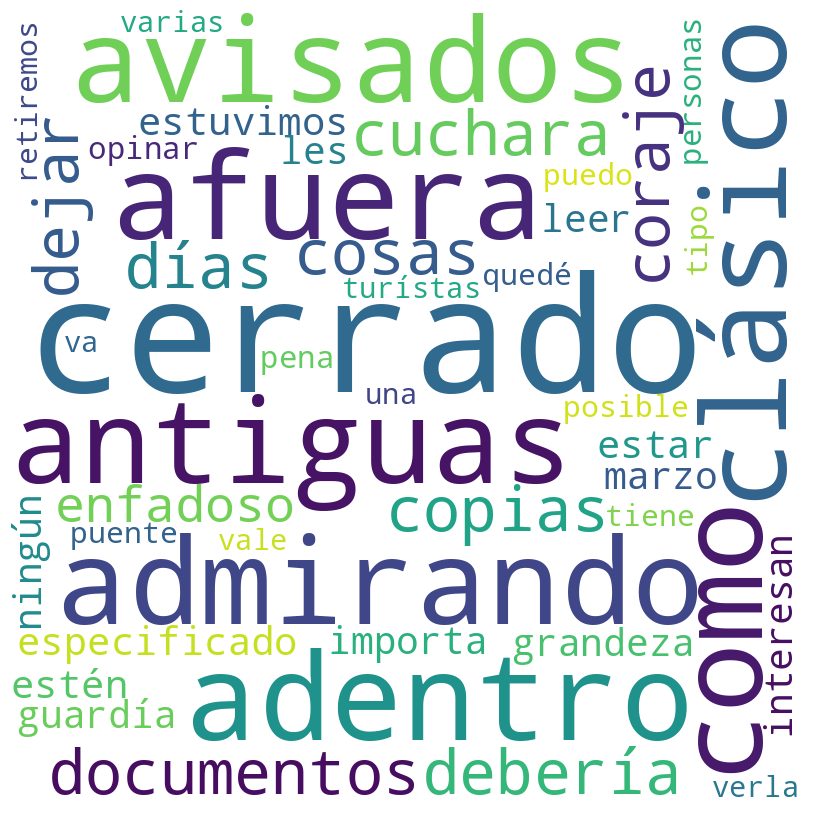

------------------------------ Casa de Diego Rivera ------------------------------


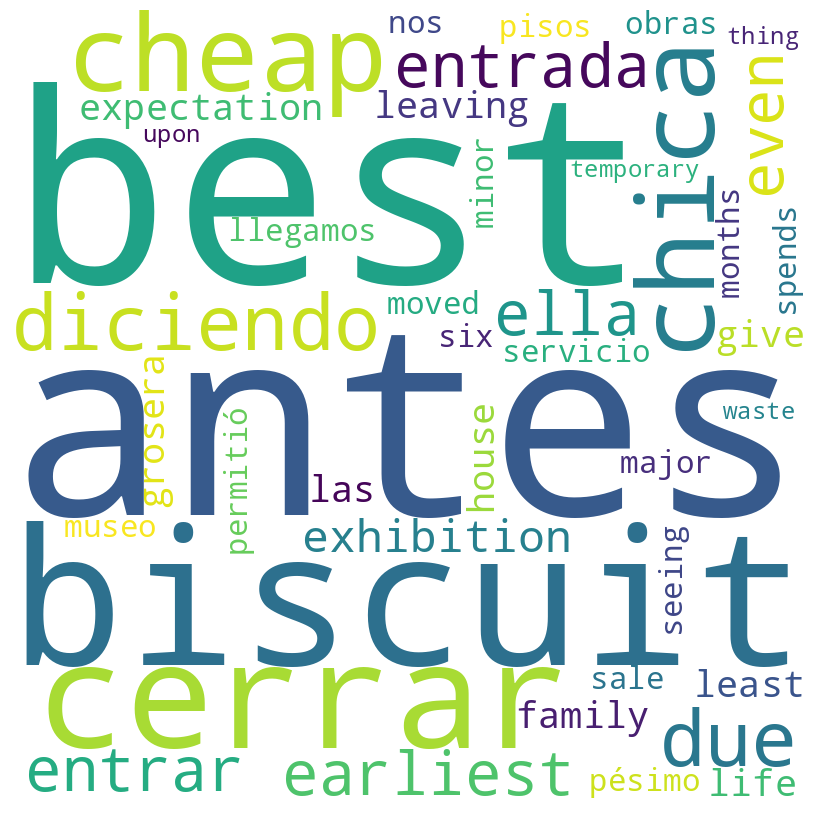

In [6]:
for spot in spots: 
    spot.negativeWordcloud()
    continue 
    break

In [7]:
for spot in spots: 
    spot.LSA()
    continue
    break

------------------------------ Teatro Juárez ------------------------------
Subgroup: Hombres
de la el es que en un teatro por los 
accoutrements hasta ningún etapa handicapped vivos oriental fathom illuminates age 
cancelería it hopefully nor lugares presentaciones vivía meeting mora typical 

Subgroup: Mujeres
de la que es el en por un teatro muy 
often país eat cuadros very venden limpieza fascinating reading sponsoring 
what artistas mientras estilo out correcto who en blocked had 

Subgroup: Turistas Nacionales
de la es que el en por un teatro muy 
mexican he aledaño pretty acontecimientos teleférico llegamos sorry even amazingly 
better cargado entraban 45 tan graciosos letrero universidad contempalr viaje 

Subgroup: Turistas Internacionales
the and is to of it in you this we 
extra edificios precioso display primer excitement vivos estado sorprende navidad 
lunes costo ancient apariencia vivo sound down américa which sé 

Subgroup: Jovenes (10, 30)
de la que es el en por teatro

------------------------------ Teatro Juárez ------------------------------
[   1    3    6    7    9   10   14   16   17   26   29   34   36   37
   39   42   44   45   52   53   58   61   69   70   74   77   79   81
   82   83   86   95   98  114  115  118  126  128  130  132  133  139
  140  146  148  149  162  169  171  177  184  187  201  204  210  217
  219  221  230  240  243  244  245  249  252  256  259  273  278  279
  287  292  297  310  316  319  320  323  330  334  344  346  347  348
  352  355  359  360  361  363  366  367  373  375  376  377  393  401
  404  409  410  413  420  421  422  423  424  425  429  433  435  440
  443  450  451  453  454  456  467  470  478  479  480  486  488  489
  496  504  506  518  520  522  530  532  536  544  545  546  547  550
  557  558  559  560  565  568  570  572  573  577  579  581  582  583
  594  598  607  610  611  615  616  623  624  628  629  632  633  636
  640  647  649  650  651  655  657  668  669  671  674  676  677  680
 

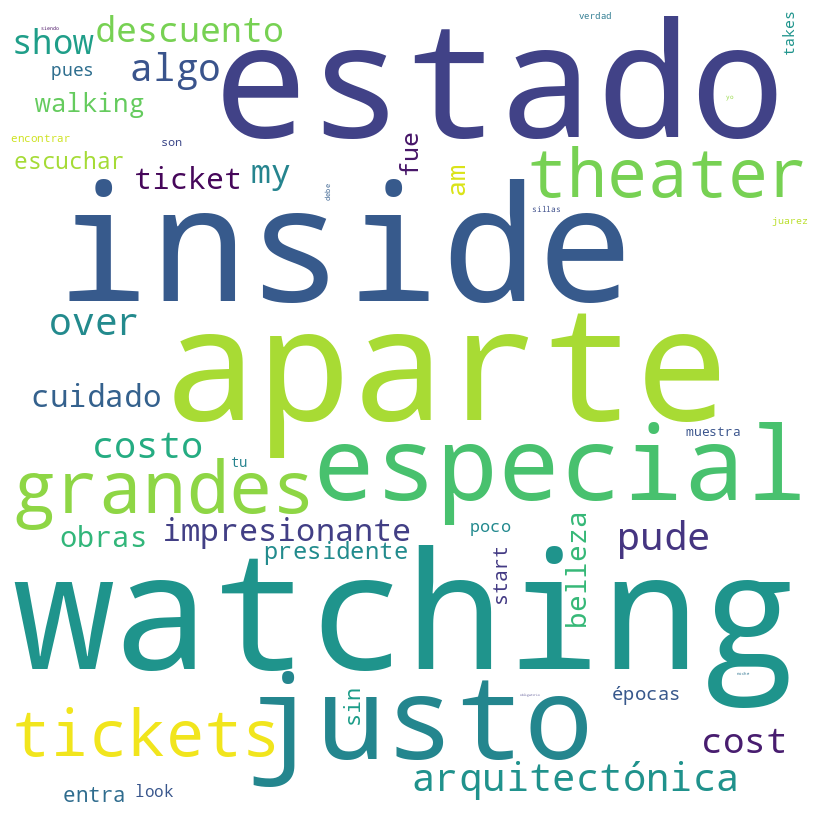

------------------------------ Mercado Hidalgo ------------------------------
[  13   18   19   21   25   29   62   63   65   80   81   83   88   91
   96   97   99  108  109  113  122  123  126  136  138  149  151  152
  153  155  165  172  173  181  182  183  186  191  195  197  199  200
  203  207  208  210  220  221  227  229  232  233  238  239  241  245
  256  262  267  270  277  294  301  304  319  326  329  334  335  339
  341  359  360  361  367  369  383  388  396  401  420  427  429  433
  439  442  444  451  457  458  462  468  475  477  479  484  486  490
  491  498  503  508  510  521  528  533  544  561  567  568  570  573
  574  575  576  578  579  583  587  588  601  602  607  608  609  623
  628  637  638  642  654  659  664  665  667  675  676  677  680  684
  687  691  694  697  703  709  711  722  723  725  733  741  747  751
  758  777  779  781  790  791  793  801  806  807  815  817  823  825
  833  834  838  848  861  869  871  885  888  892  898  902  904  906

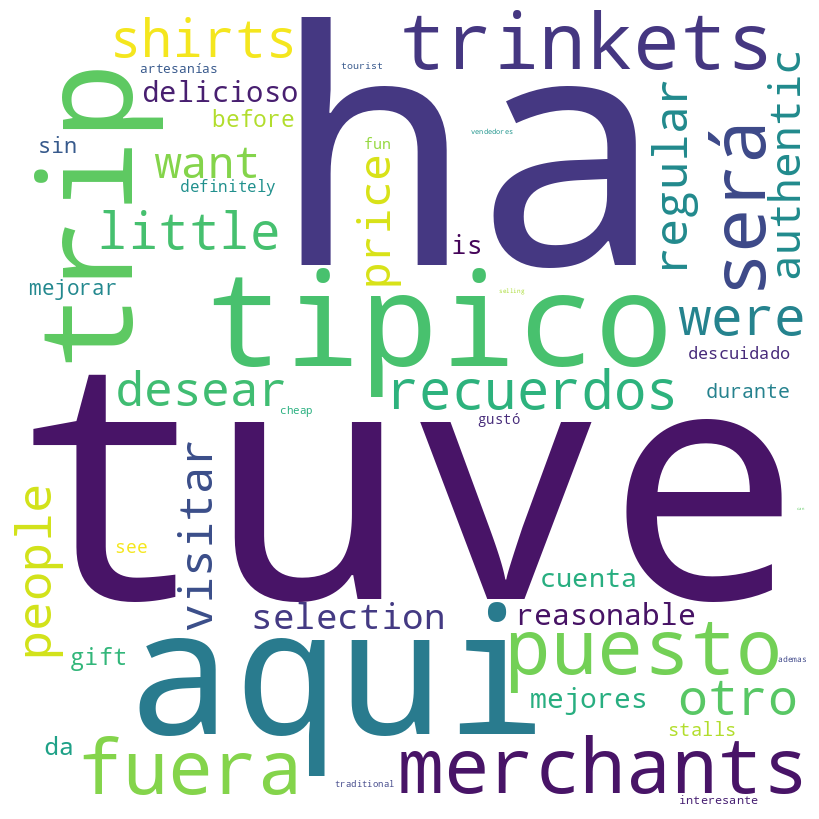

------------------------------ Museo de las Momias ------------------------------
[   2    3   28   34   37   39   43   45   77   81  101  106  107  117
  124  125  145  153  156  161  162  165  166  167  168  173  188  196
  199  207  208  211  212  215  216  218  224  229  230  242  245  258
  261  277  283  293  295  305  307  318  328  343  344  346  352  357
  378  383  393  403  407  408  409  413  425  435  436  454  456  467
  468  471  496  508  511  519  520  529  530  533  535  538  539  540
  546  551  554  558  560  562  564  569  570  572  576  581  582  584
  589  594  595  597  599  600  606  611  614  623  630  641  644  659
  662  678  679  683  685  695  696  698  699  700  704  705  708  709
  710  719  721  723  728  729  733  747  750  754  756  758  763  776
  795  810  815  822  825  827  830  832  833  837  847  865  866  871
  872  875  881  890  903  913  914  916  926  934  948  950  957  958
  969  988  991 1001 1003 1007 1008 1025 1026 1028 1038 1039 1047 

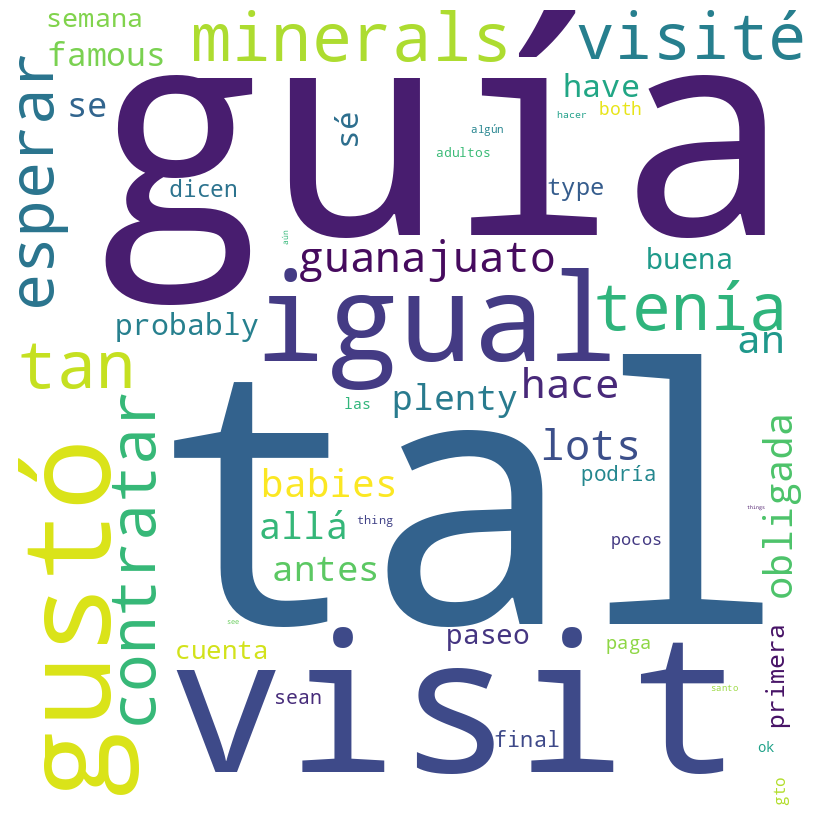

------------------------------ Basilica Colegiata ------------------------------
[   1   12   14   17   24   25   28   30   32   34   38   47   51   52
   54   56   58   60   64   66   74   82   93   98  109  110  111  112
  113  117  121  123  124  125  126  127  131  145  153  156  157  166
  170  171  174  181  185  187  190  191  197  201  202  208  214  218
  227  231  232  234  237  239  251  253  255  258  269  270  285  299
  300  303  315  321  325  326  328  334  335  336  344  347  352  356
  359  374  378  384  385  394  395  397  398  407  412  414  422  429
  431  438  439  444  446  456  461  464  466  469  472  474  476  480
  481  482  485  487  491  494  496  497  500  502  504  505  508  510
  514  536  539  546  550  556  557  559  560  561  564  565  572  581
  584  588  589  592  602  604  606  612  630  642  649  650  652  658
  661  662  663  667  674  675  678  680  697  698  700  703  713  716
  718  719  721  722  726  729  737  741  749  751  758  760  771  

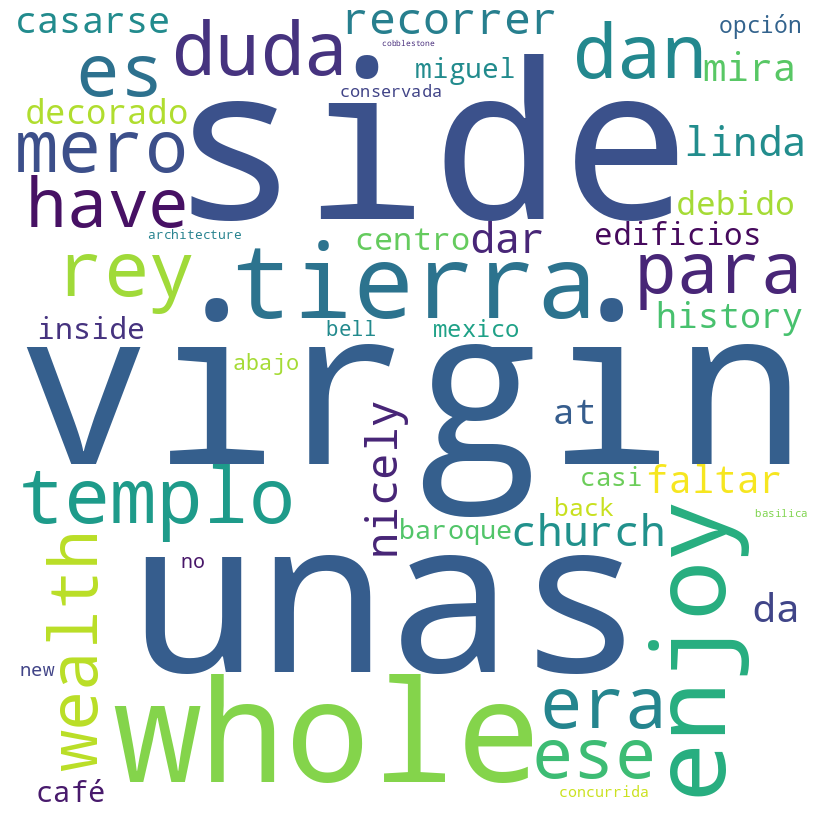

------------------------------ Universidad de Guanajuato ------------------------------
[   2    6   13   17   25   28   33   38   41   42   45   46   50   51
   55   60   71   80   83   84   86   87   88   90   94  101  108  113
  118  135  137  138  140  142  143  147  152  157  158  160  164  169
  172  175  180  183  188  191  194  196  203  207  208  210  211  212
  214  218  220  232  233  234  237  239  250  252  255  259  261  264
  267  268  271  277  290  291  293  296  298  303  304  308  312  313
  314  318  319  322  327  328  331  335  337  342  343  344  346  347
  362  371  375  376  380  384  385  388  391  398  400  402  413  415
  417  420  428  432  438  441  447  448  450  457  462  463  467  470
  473  474  477  488  490  491  494  497  501  502  503  519  525  531
  535  537  540  543  548  554  556  558  560  562  566  569  570  573
  575  576  578  580  582  587  589  590  597  602  606  608  609  612
  613  615  622  628  629  635  639  642  647  653  658  660

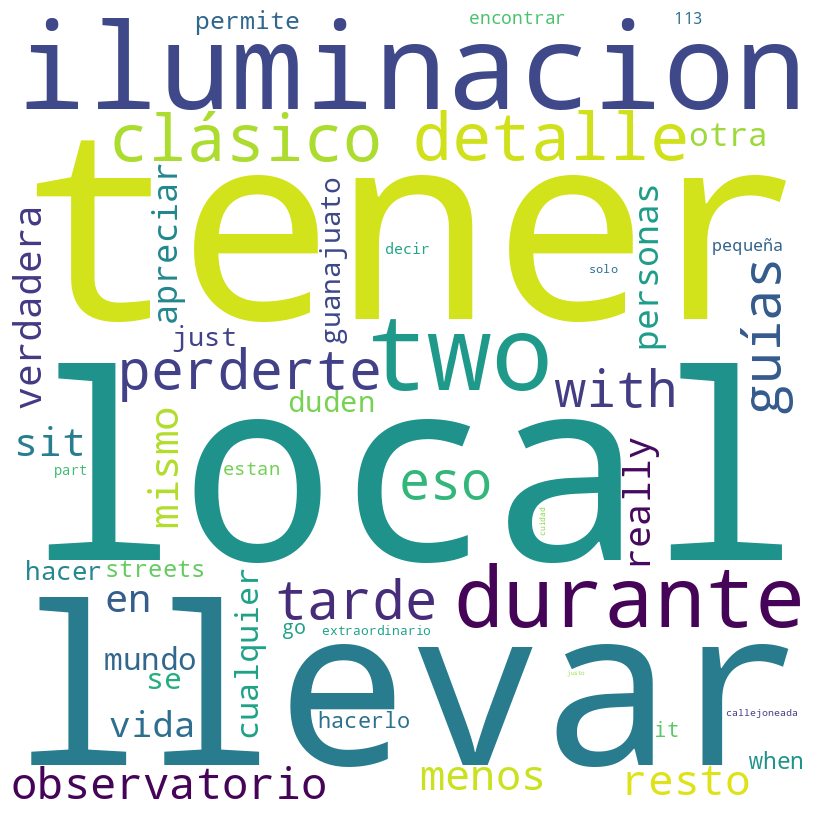

------------------------------ Jardín de la Unión ------------------------------
[   0   10   24   25   31   32   33   46   49   54   56   72   73   81
   84   88   90   91   92   97  105  107  109  112  114  116  122  123
  124  139  141  146  157  160  163  165  174  182  183  191  199  200
  201  204  211  216  217  218  222  224  229  231  241  246  250  257
  262  267  275  276  283  284  287  289  298  303  319  321  327  328
  331  335  336  340  341  349  354  363  364  365  370  379  388  395
  397  399  400  404  410  411  416  420  423  431  437  439  440  443
  447  448  461  462  465  468  471  485  486  490  496  497  501  502
  504  515  517  519  527  529  531  534  536  537  539  547  556  561
  563  565  566  568  570  573  575  577  580  581  582  588  589  591
  593  597  599  625  634  636  637  639  646  652  656  666  668  669
  671  673  676  682  684  688  689  692  699  702  710  714  724  725
  729  746  747  749  759  760  761  763  768  775  778  790  799  

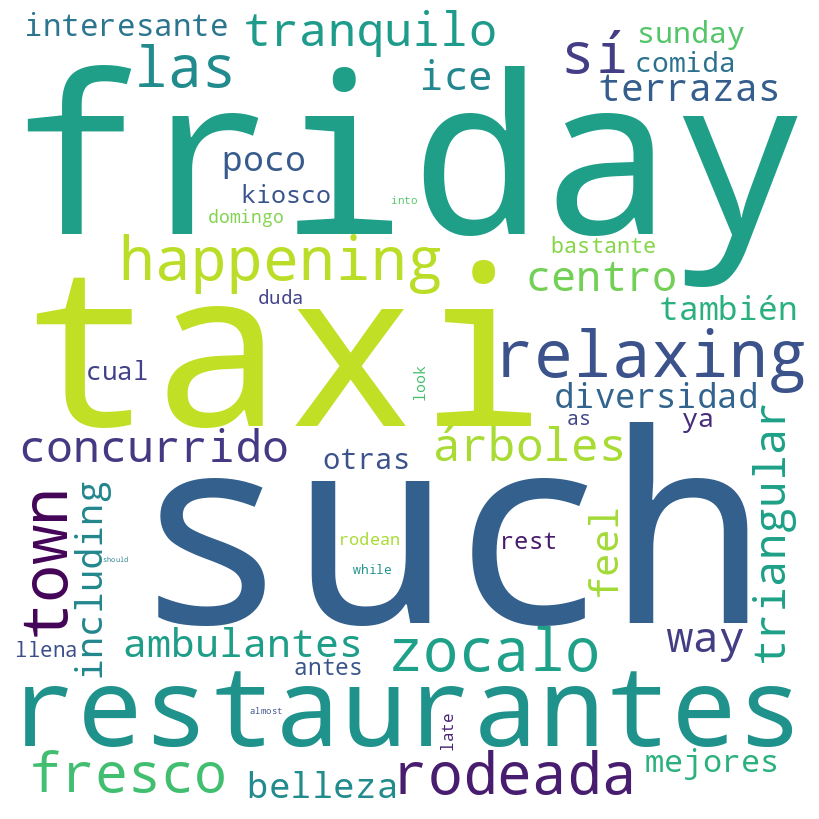

------------------------------ Callejón del Beso ------------------------------
[  12   13   16   17   20   25   26   28   32   41   42   44   46   47
   57   66   68   72   78   79   81   89   94   98  105  108  115  117
  118  125  128  130  136  141  160  161  167  174  175  181  183  195
  200  210  215  216  217  220  221  222  225  226  229  230  239  240
  242  260  267  275  283  284  286  290  298  302  306  307  312  315
  321  323  326  329  330  335  340  343  347  356  380  384  385  388
  392  399  403  405  407  410  416  422  423  426  431  439  443  446
  449  456  458  459  460  464  465  466  473  478  493  503  505  506
  511  514  518  539  542  545  548  551  552  553  554  559  570  573
  577  578  581  583  584  586  588  590  593  594  603  604  605  609
  616  618  625  626  627  628  635  643  644  645  646  657  658  662
  665  670  682  693  695  701  705  707  708  709  721  725  729  733
  740  745  752  756  758  763  764  767  791  806  809  810  812  8

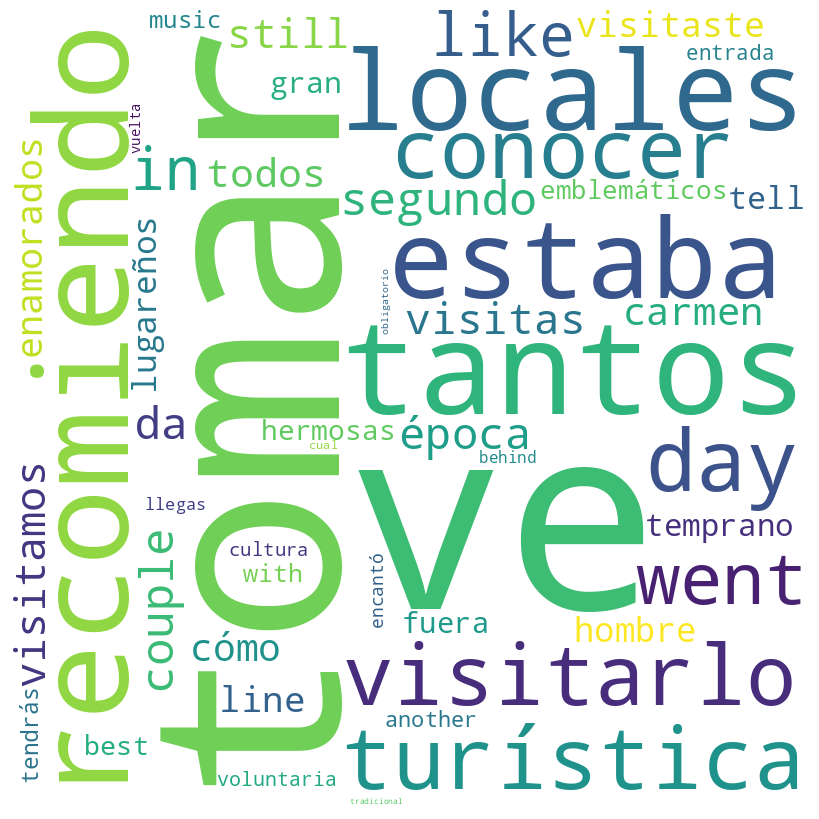

------------------------------ Monumento Pípila ------------------------------
[  11   14   23   29   30   31   38   42   45   46   48   49   50   51
   52   58   63   67   71   73   74   76   77   83   86   94   97  101
  104  106  111  116  121  122  123  131  147  148  154  156  157  159
  167  170  171  179  198  199  202  205  207  210  213  215  217  218
  222  223  227  234  239  245  249  258  259  261  262  269  272  273
  275  278  279  280  281  286  294  299  301  302  303  304  306  307
  308  317  322  335  336  339  342  343  347  351  355  357  358  371
  379  385  392  393  395  401  403  407  418  419  429  431  437  443
  450  451  464  471  477  478  480  482  487  491  492  493  496  508
  517  518  519  530  536  538  549  557  559  563  565  566  568  569
  570  572  573  574  576  579  582  583  591  593  595  603  606  607
  619  620  626  635  638  641  654  663  664  666  671  675  682  688
  695  697  706  708  709  710  711  712  715  718  719  720  728  73

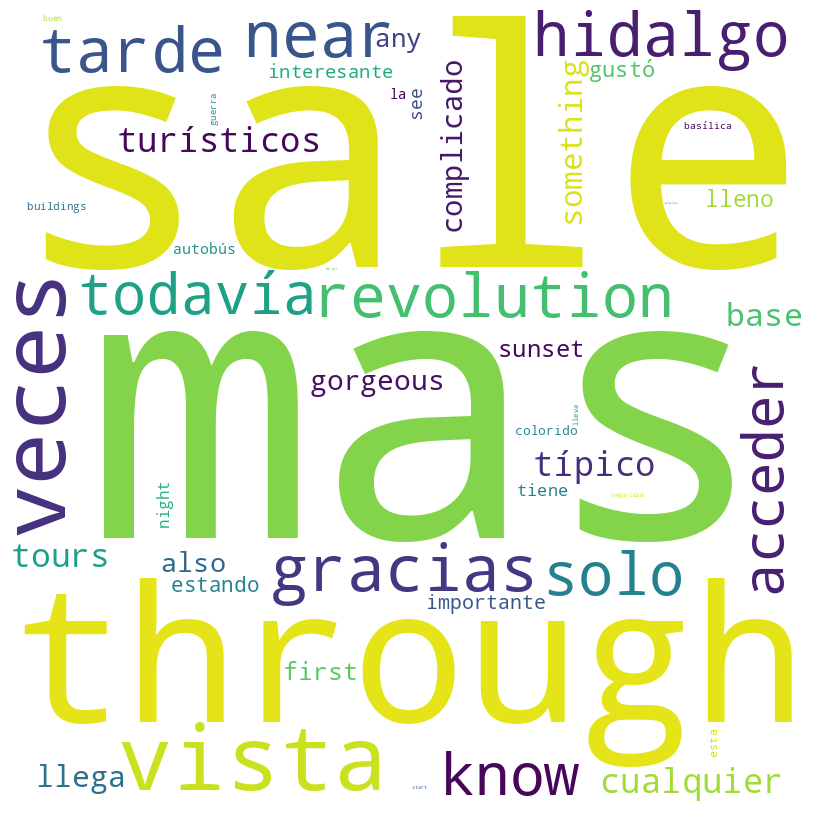

------------------------------ Alhóndiga ------------------------------
[   1    7   11   12   16   17   18   24   29   33   36   46   54   55
   58   76   78   80   81   84   86   92   99  110  118  123  129  130
  134  135  140  141  147  151  164  166  167  169  170  172  174  179
  181  183  190  202  205  209  210  212  217  231  233  234  235  239
  245  254  255  257  258  261  262  264  266  271  276  278  284  289
  291  293  294  296  297  298  299  300  301  303  308  312  316  319
  325  327  328  335  336  337  345  351  354  363  365  366  367  369
  370  379  393  394  401  408  411  413  416  419  423  431  434  442
  443  445  455  460  462  470  475  478  480  481  487  493  519  524
  526  527  533  534  538  549  555  557  567  581  588  592  601  602
  605  611  617  619  620  623  624  626  628  630  634  636  640  644
  645  650  658  659  660  661  667  668  670  673  675  676  683  688
  690  691  700  702  704  705  712  719  724  725  726  727  728  730
  733

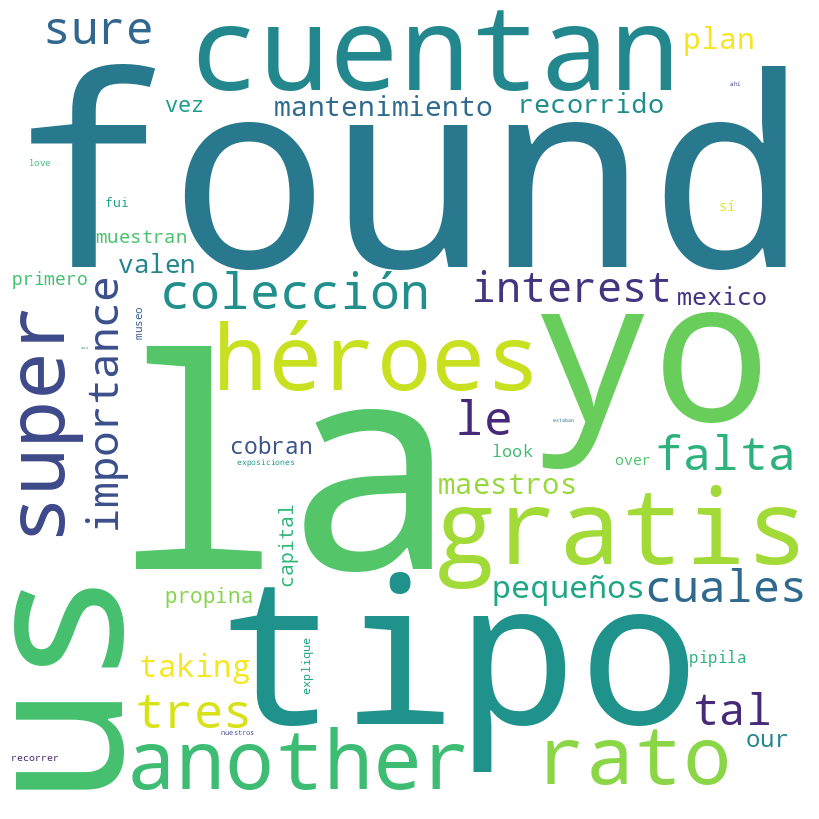

------------------------------ Casa de Diego Rivera ------------------------------
[   3    4    8    9   11   13   17   19   35   36   54   56   59   60
   61   65   72   80   81   85   86   92  108  109  111  115  116  117
  119  125  131  145  148  150  151  176  178  186  189  193  195  196
  199  200  209  211  218  222  224  230  232  238  241  242  243  246
  254  255  259  260  263  264  267  272  275  276  277  285  288  289
  292  302  303  307  310  313  314  315  319  320  333  335  345  347
  349  350  360  374  376  384  396  397  413  427  430  433  445  452
  456  466  470  478  484  486  489  496  509  517  520  537  538  548
  550  551  560  567  568  572  576  577  579  580  582  598  600  602
  604  607  614  616  620  622  624  625  627  634  646  647  649  653
  659  661  662  668  672  674  675  679  681  683  684  690  695  708
  709  712  719  721  730  753  763  765  766  767  768  777  786  789
  790  805  807  812  813  815  827  836  840  849  853  858  859

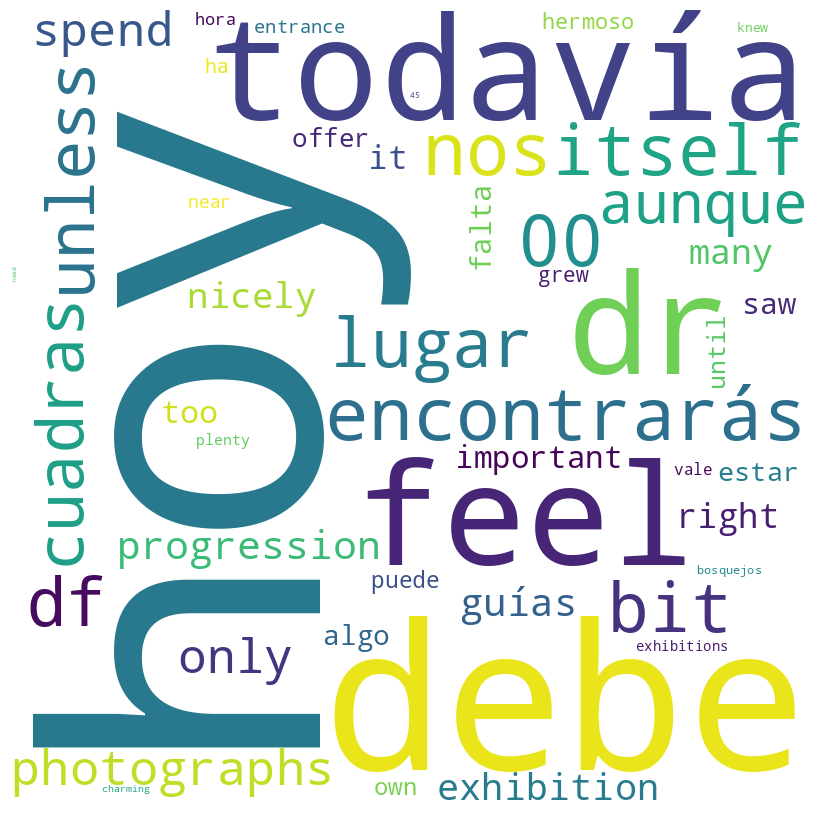

In [8]:
for spot in spots: 
    spot.ngramsAnalysis()
    continue
    break

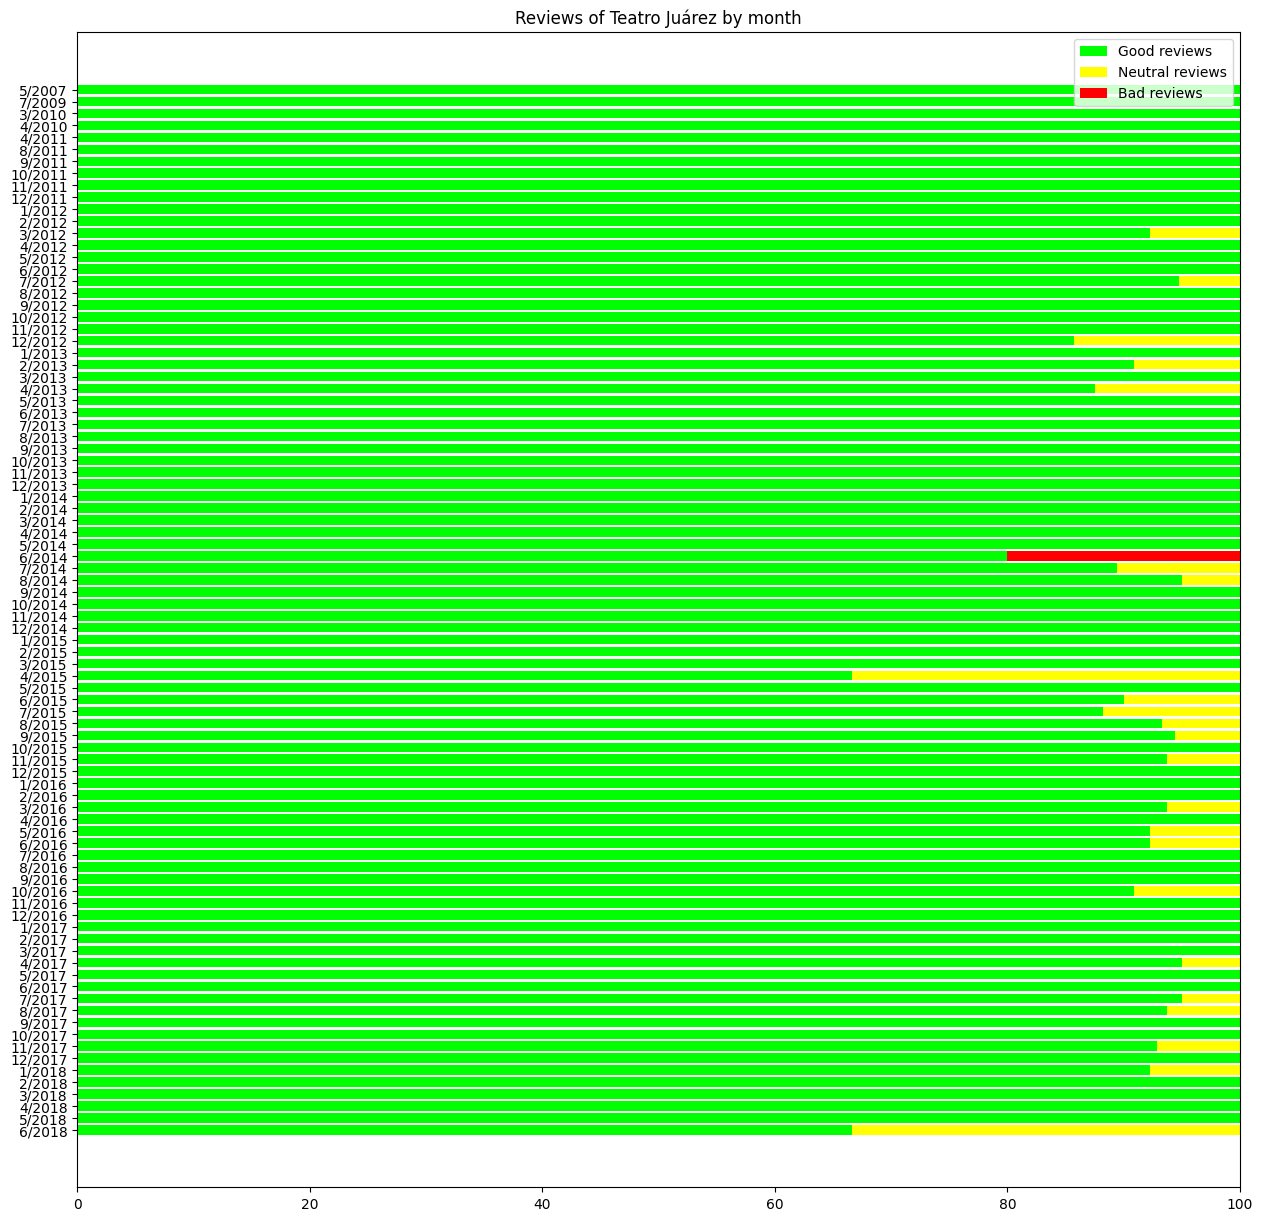

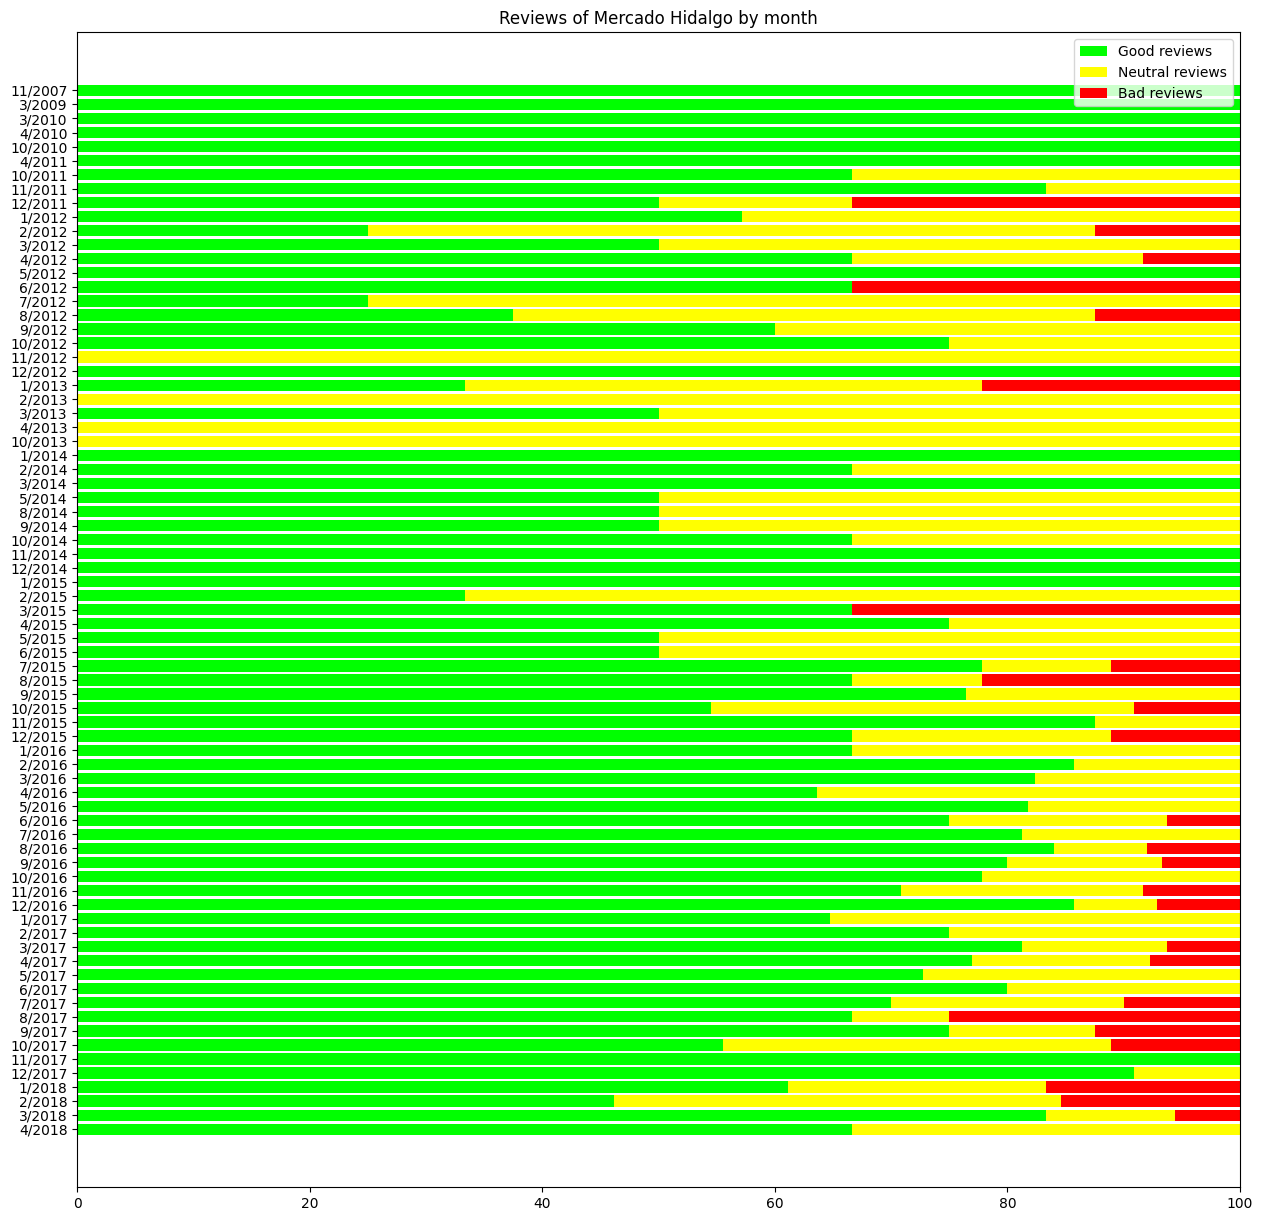

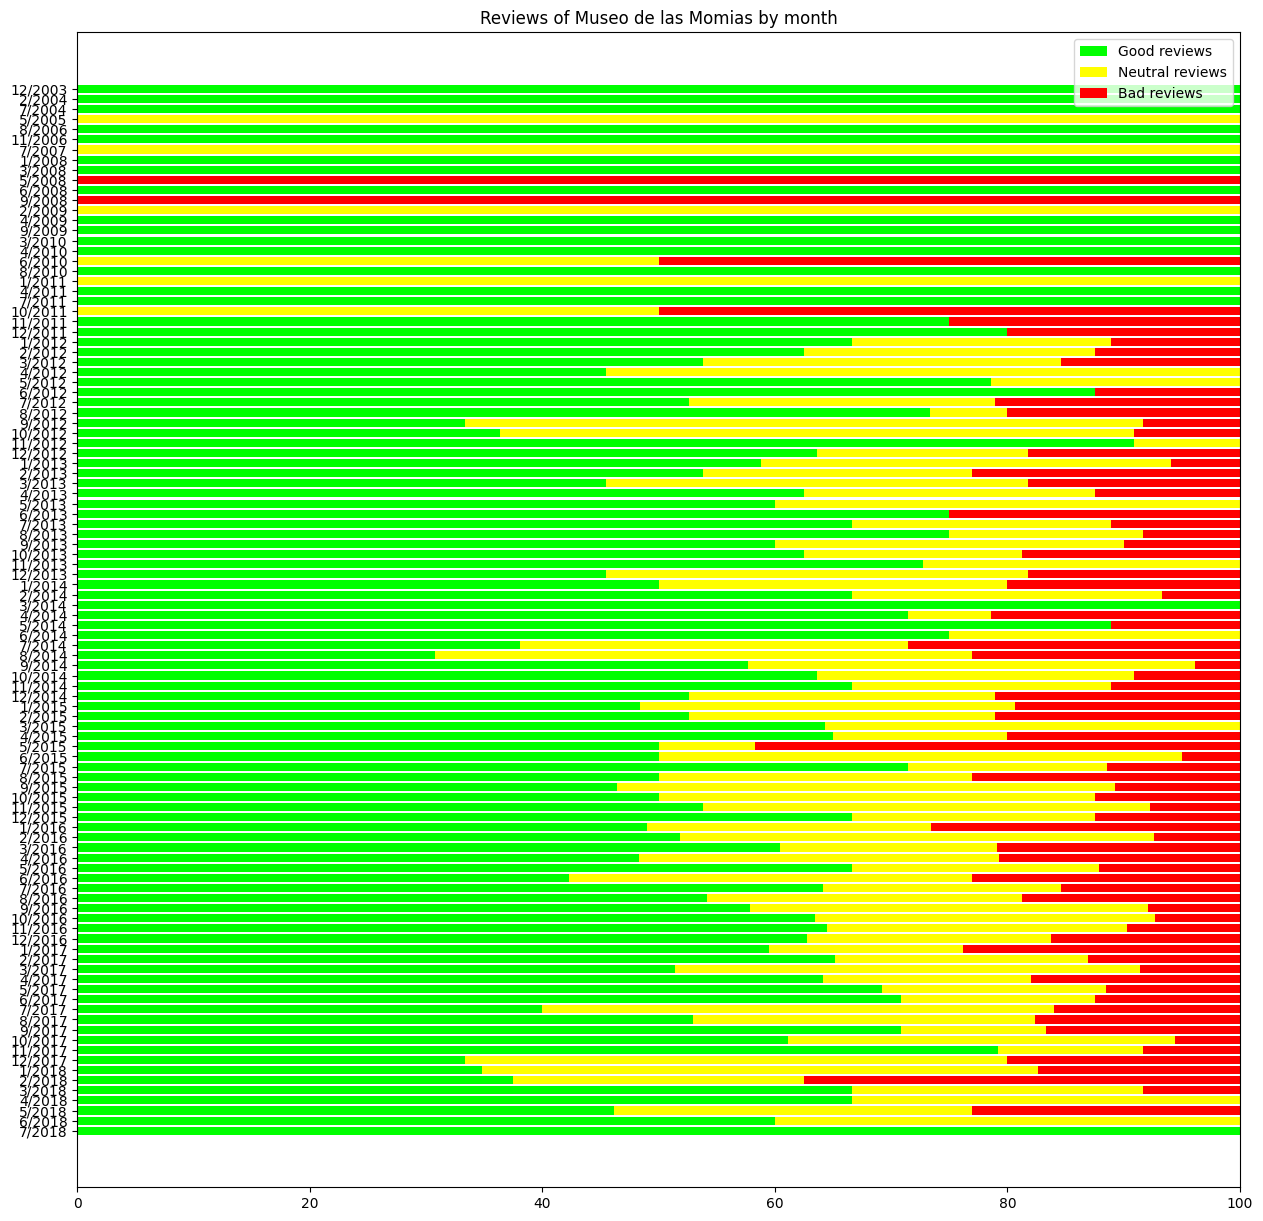

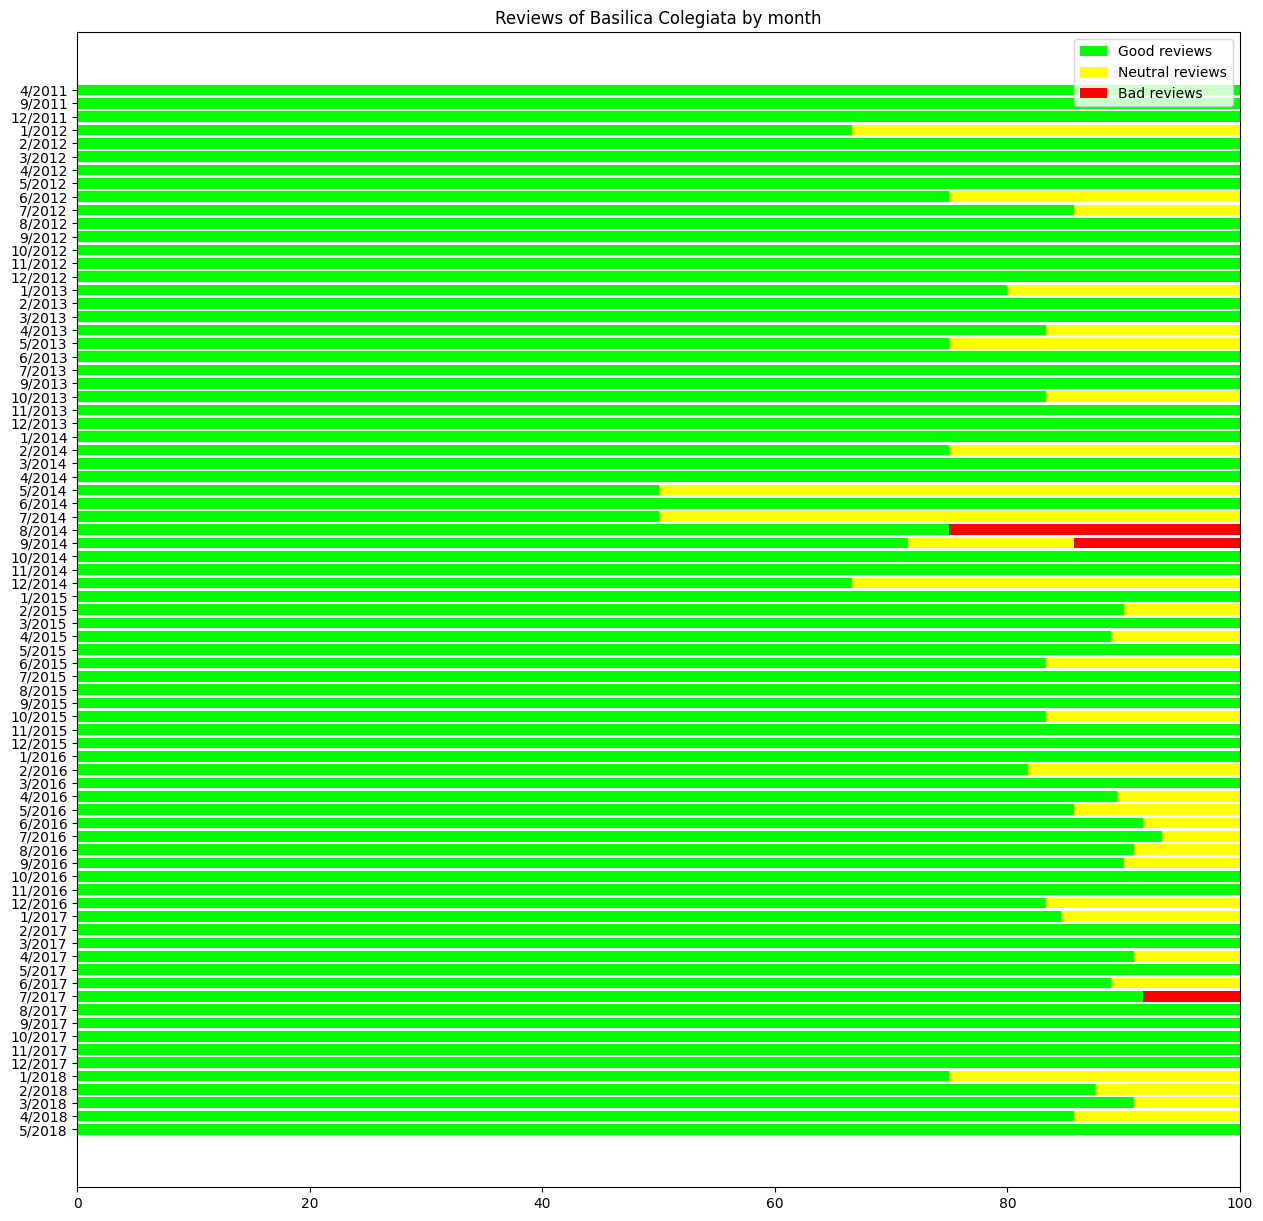

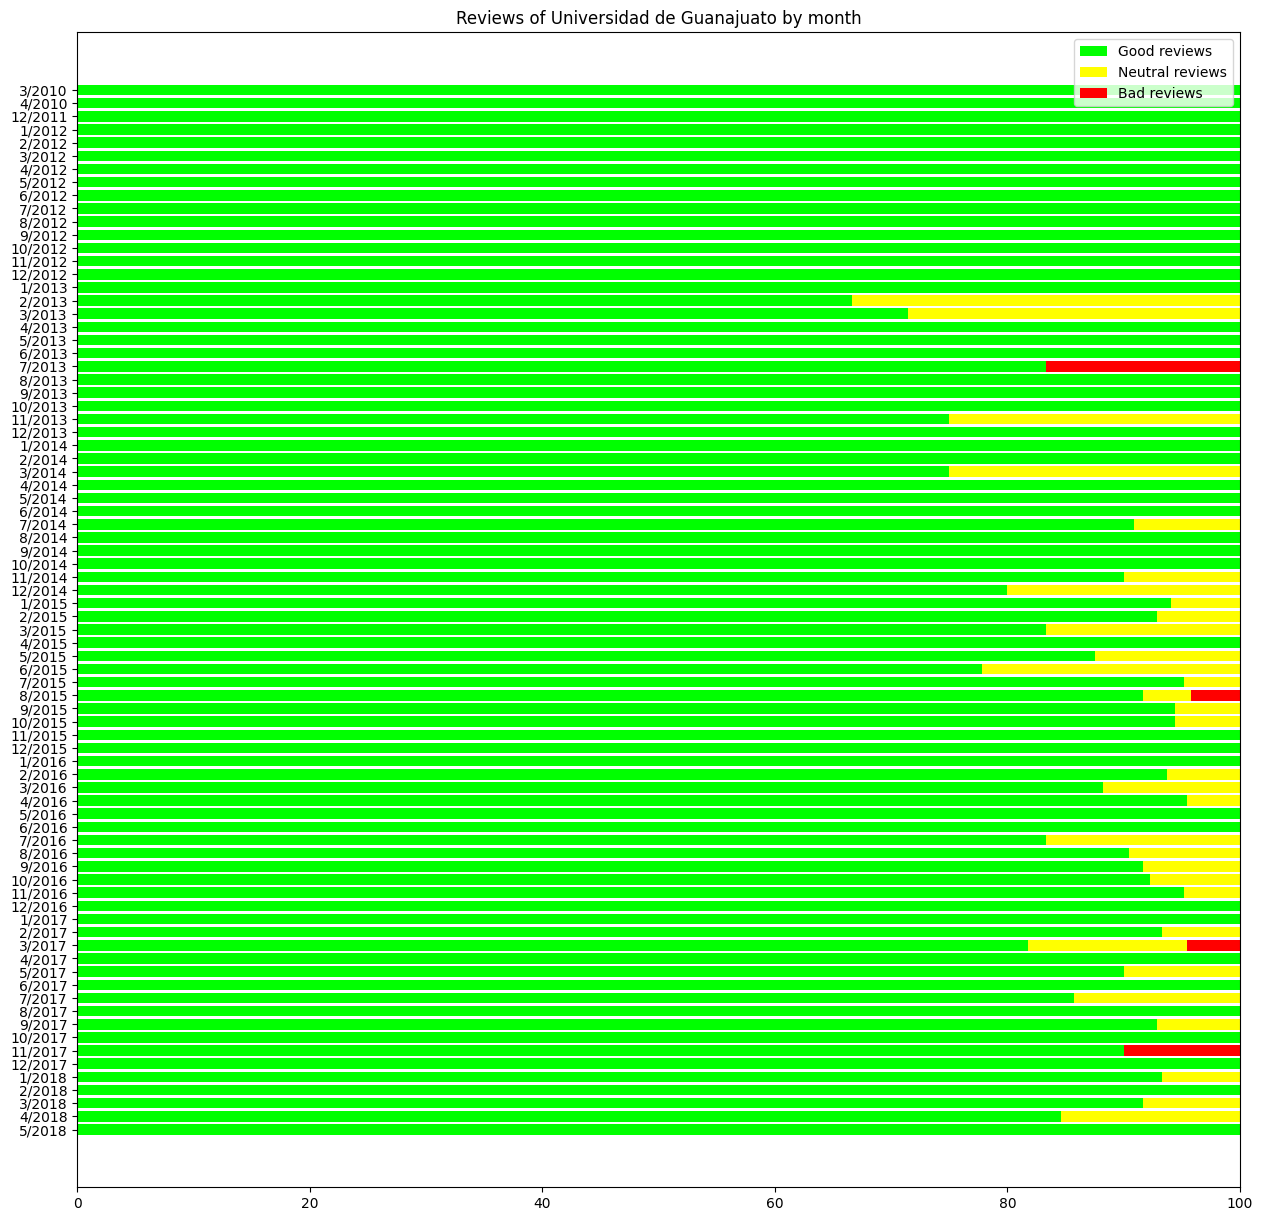

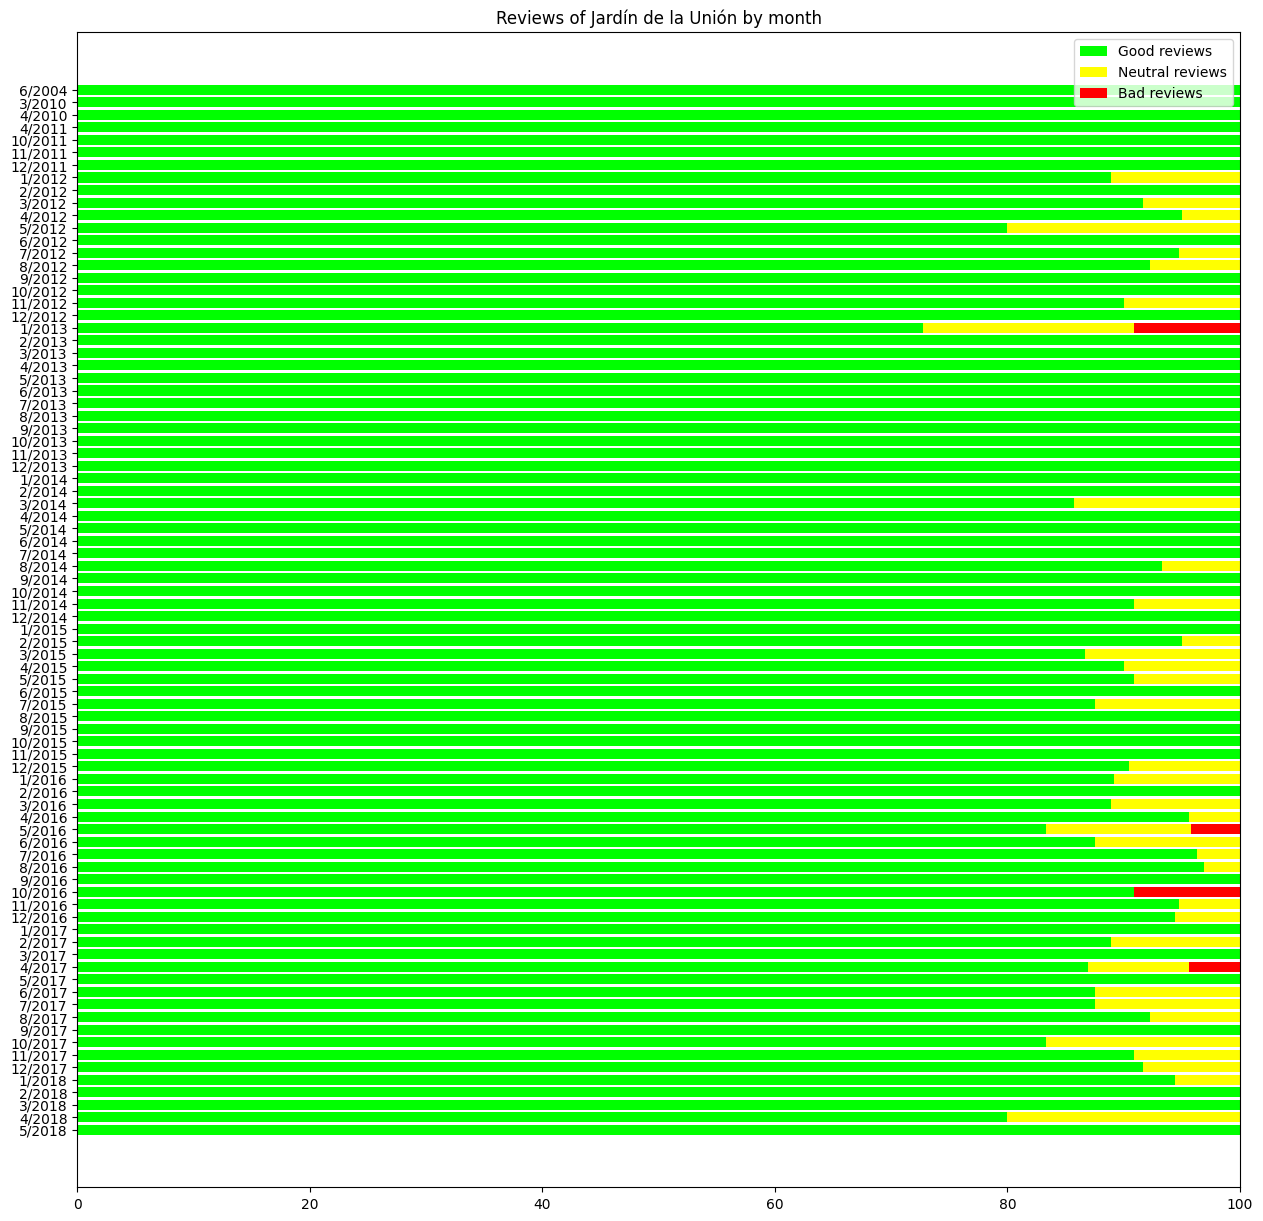

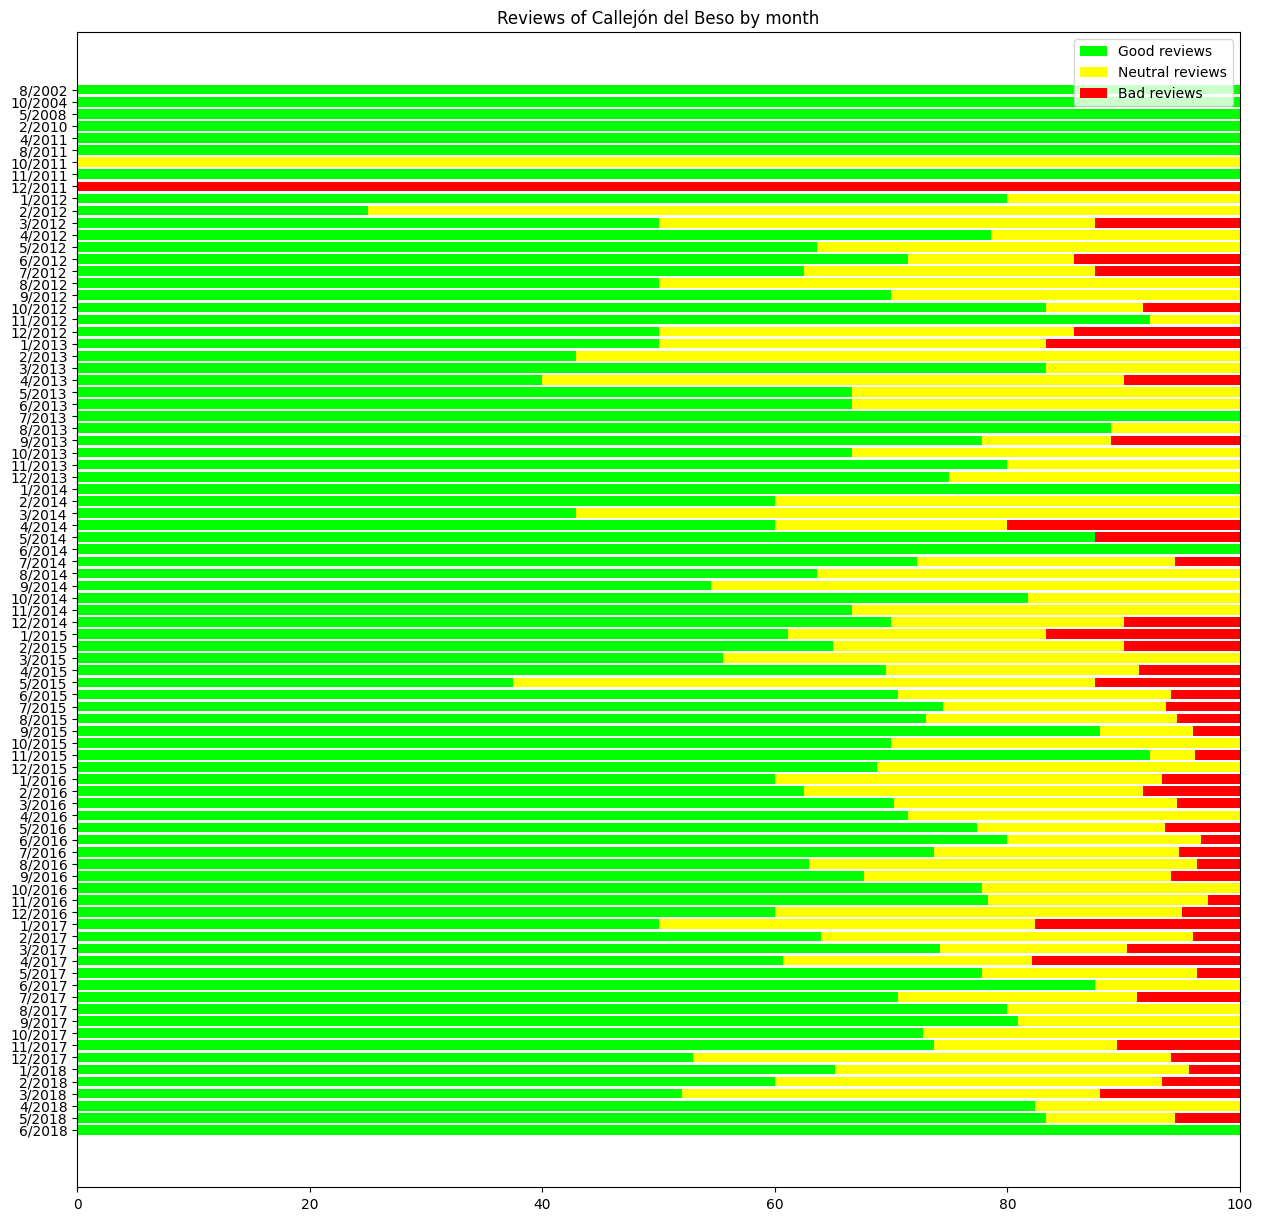

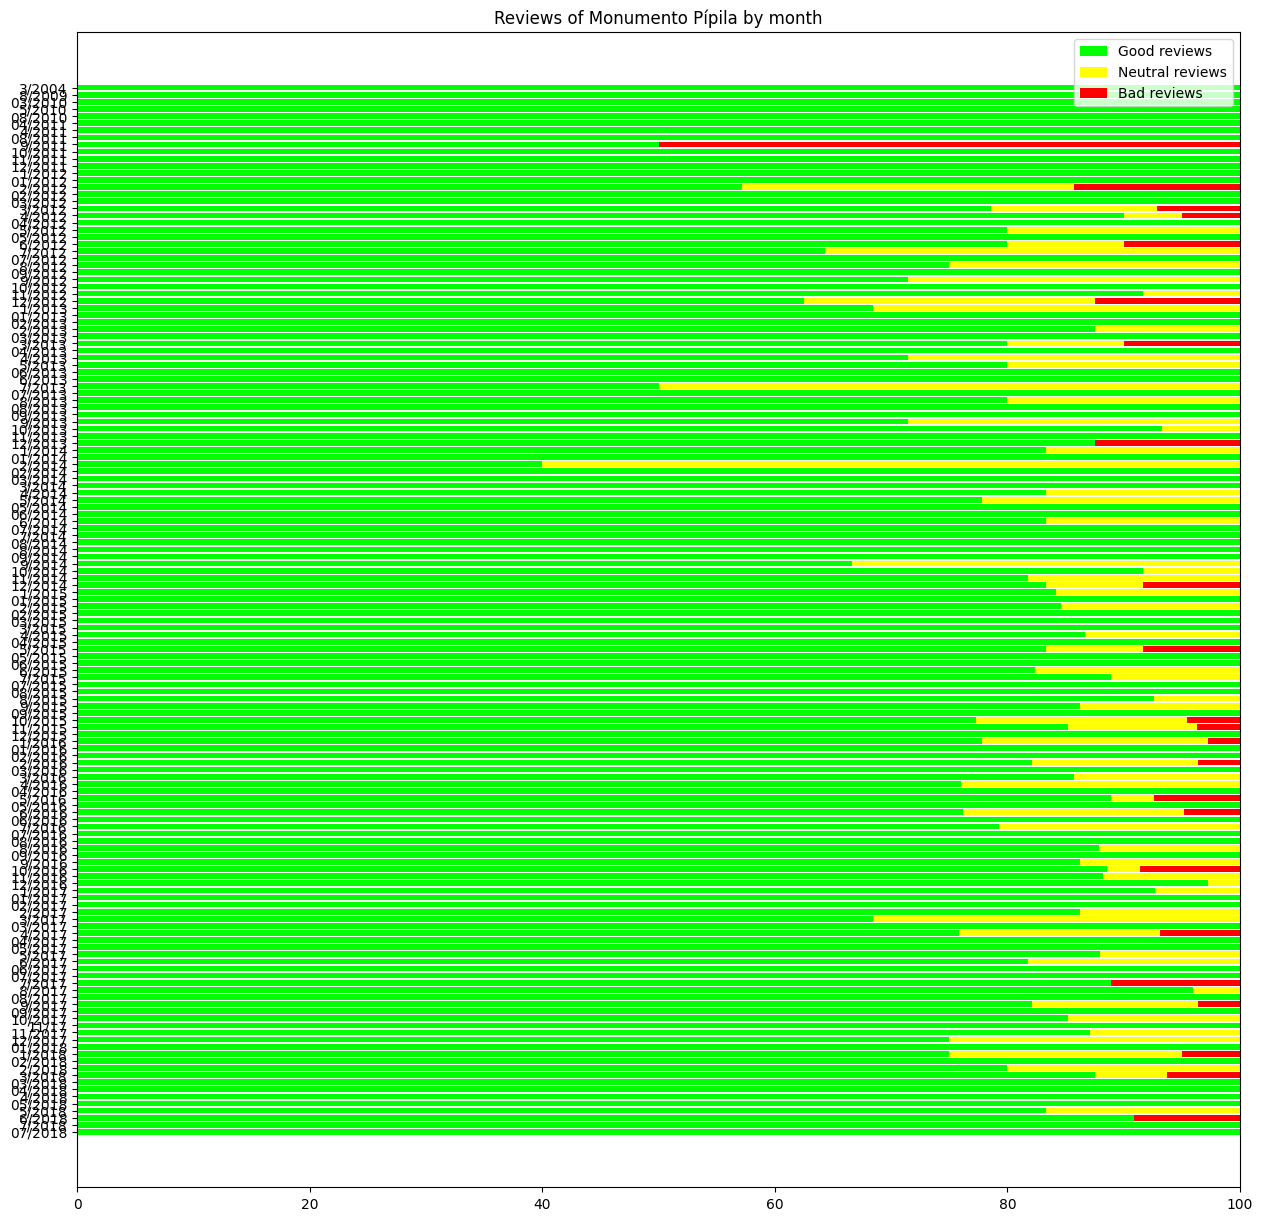

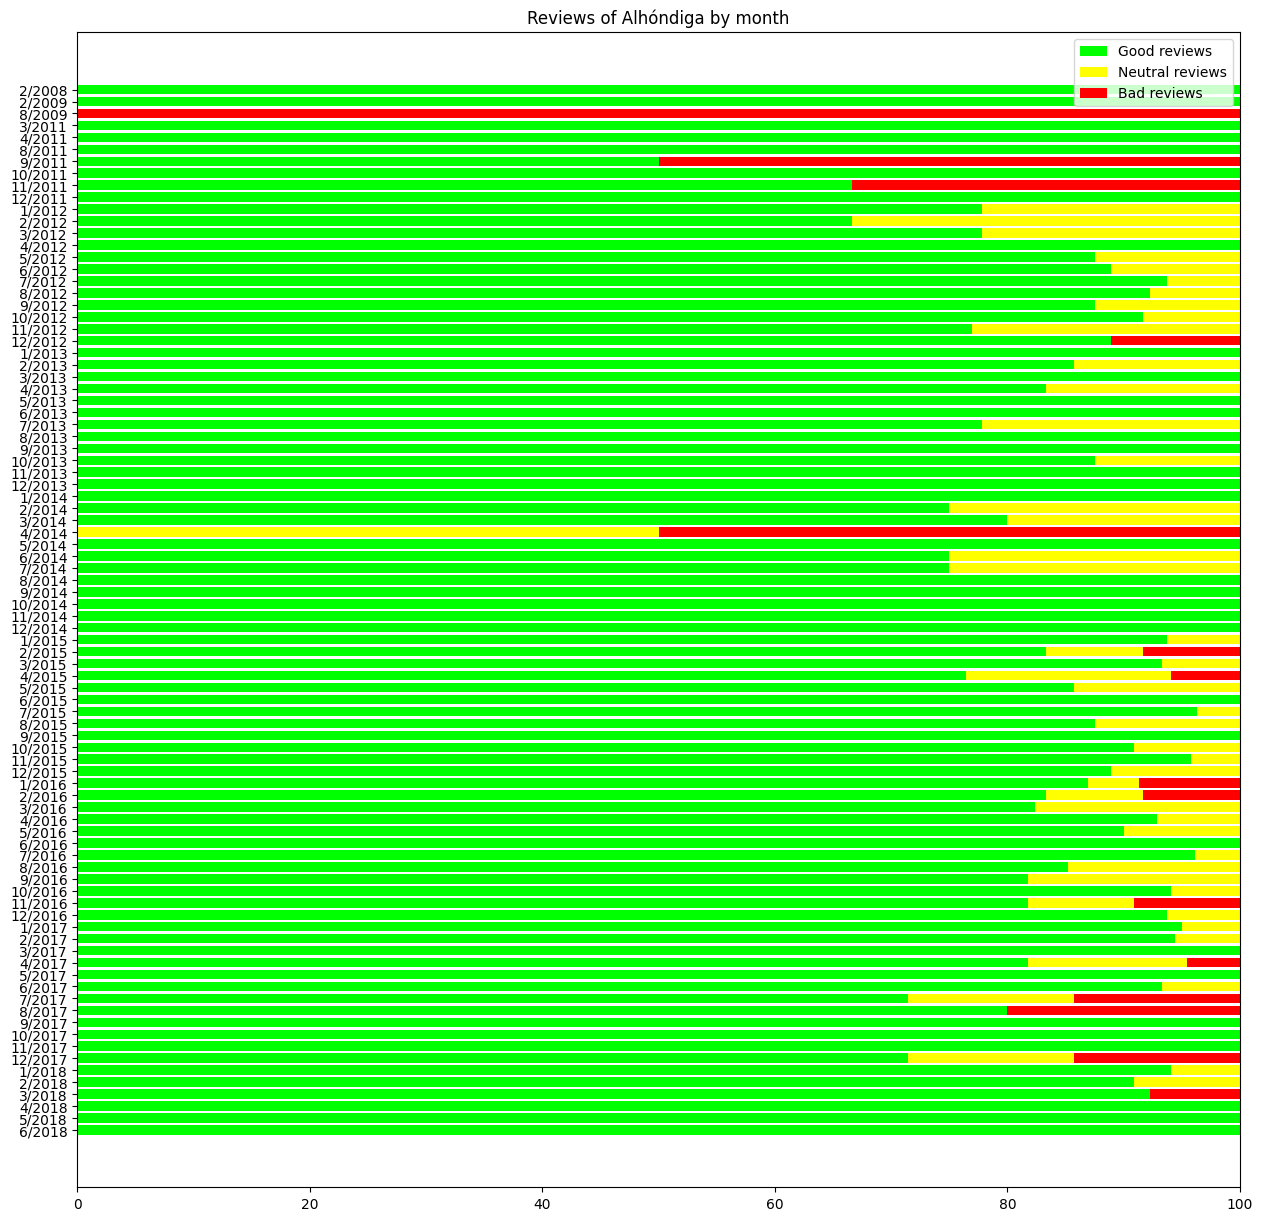

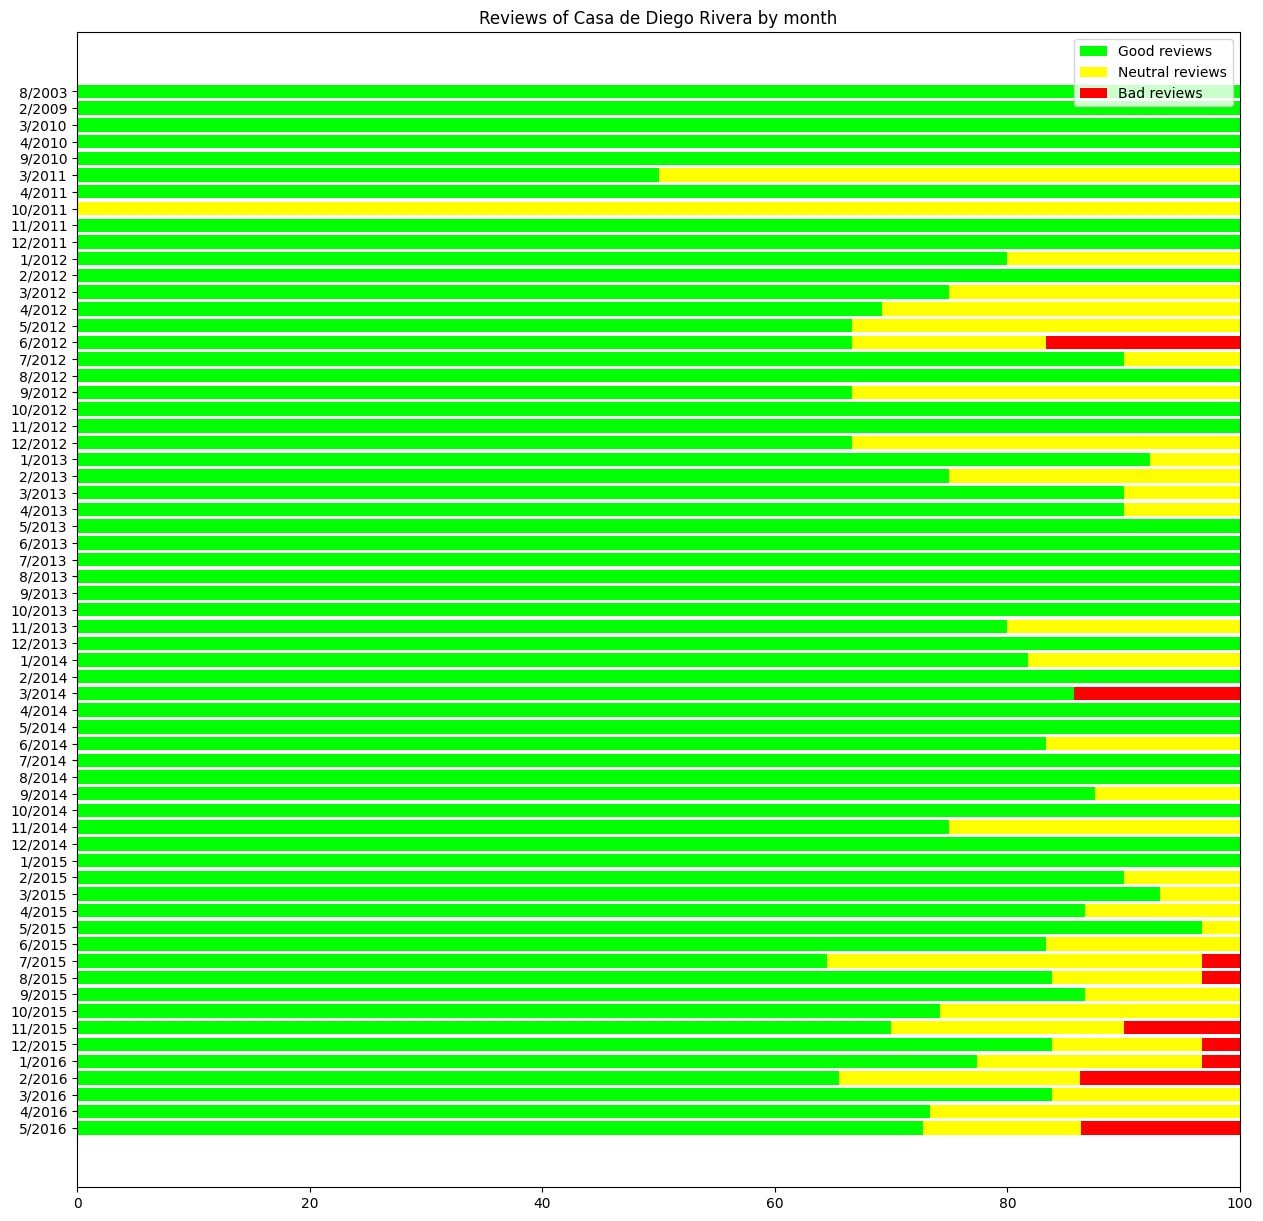

In [9]:
for spot in spots: 
    spot.temporalAnalysis()
    continue
    break

## Preguntas

**1. (10pts) ¿De los sitios turísticos, cual diría usted que es el más polémico y la razón de
ello?**

**2. (10pts) En cuanto al sitio más polémico, ¿Como es la diferencia de opinión y temas entre
turistas nacionales e internacionales?**

**3. (10pts) ¿Cual diría que es el sitio que le gusta más a las mujeres y por qué?**

**4. (10pts) ¿Cual diría que es el sitio que le gusta más a las personas jóvenes y por qué?**

**5. (10pts) ¿Qué otras observaciones valiosas puede obtener de su análisis? (e.g., ¿identificó de que se queja la gente? ¿qué tipo de cosas le gustó a la gente?, etc.)**